In [1]:
import pandas as pd
import requests
import os
from PIL import Image
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
import cv2
from sklearn.metrics import confusion_matrix, classification_report
import time
from transformers import AutoModelForImageClassification

df = pd.read_csv('cs552j_A1_dataset_image_id_url.csv')

In [14]:
# Folder where you want to save the image
save_folder = "a1_images"
os.makedirs(save_folder, exist_ok=True)

In [ ]:
def download_image(image_url, save_folder):
    image_name = os.path.join(save_folder, image_url.split("/")[-1])
    response = requests.get(image_url)
    if response.status_code == 200:
        with open(image_name, "wb") as file:
            file.write(response.content)
        print(f"Image saved at: {image_name}")
    else:
        print("Failed to download image")

In [ ]:
# # downloads all the images to your computer. Do this only once locally, then you can continue.

for i in df.coco_url.values:
    download_image(i, save_folder)

# Your Assessment code below

- please make good use of markdown to separate the sections. 

#### Remaniming filename with id_lable format fo reasy access and test

In [ ]:

image_folder = "images"

for index, row in df.iterrows():
    old_name = row["file_name"]  # Original filename
    label = str(row["label"]).replace(" ", "_") 

    old_path = os.path.join(image_folder, old_name)
    name, ext = os.path.splitext(old_name)
   
    new_name = f"{name}_{label}{ext}"
    new_path = os.path.join(image_folder, new_name)

    if os.path.exists(old_path):
        os.rename(old_path, new_path)
        print(f"Renamed: {old_name} → {new_name}")
    else:
        print(f"Skipping {old_name}: File not found.")

print("Image renaming completed!")


### Exploring dimensions of the images

The below code snoppents are for exploration of minimum, maximum and average of height, width and DPI of the images and these value distributions were also checked to undestand the variations

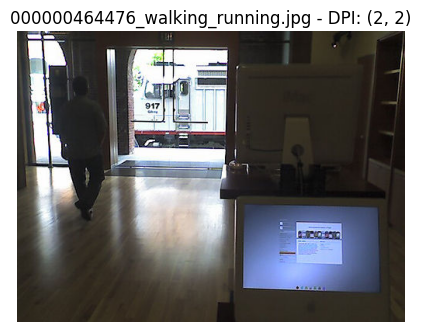

Min Size: (300, 240) (width x height in pixels)
Max Size: (640, 640) (width x height in pixels)
Average Size: (563.6080586080586, 501.27106227106225) (width x height in pixels)
Format Counts: {'JPEG': 273}
Min DPI: (2, 2)
Max DPI: (4800, 4800)
Average DPI: (132.00732600732601, 132.00732600732601)


In [5]:
dataset_path = "images"

image_files = [f for f in os.listdir(dataset_path)]

widths = []
heights = []
formats = []
resolutions = []

for img_file in image_files:
    img_path = os.path.join(dataset_path, img_file)
    
    with Image.open(img_path) as img:
        widths.append(img.width)
        heights.append(img.height)
        formats.append(img.format)

        dpi = img.info.get("dpi", (72, 72))
        resolutions.append(dpi)
        if dpi[0] < 50 or dpi[1] < 50:
            plt.figure(figsize=(5, 5))
            plt.imshow(img)
            plt.axis("off")
            plt.title(f"{img_file} - DPI: {dpi}")
            plt.show()

min_size = (min(widths), min(heights))
max_size = (max(widths), max(heights))
avg_size = (np.mean(widths), np.mean(heights))
format_counts = Counter(formats)

if resolutions:
    dpi_x, dpi_y = zip(*resolutions)
    min_dpi = (min(dpi_x), min(dpi_y))
    max_dpi = (max(dpi_x), max(dpi_y))
    avg_dpi = (np.mean(dpi_x), np.mean(dpi_y))
else:
    min_dpi = max_dpi = avg_dpi = "No DPI data found"

print(f"Min Size: {min_size} (width x height in pixels)")
print(f"Max Size: {max_size} (width x height in pixels)")
print(f"Average Size: {avg_size} (width x height in pixels)")
print(f"Format Counts: {dict(format_counts)}")
print(f"Min DPI: {min_dpi}")
print(f"Max DPI: {max_dpi}")
print(f"Average DPI: {avg_dpi}")


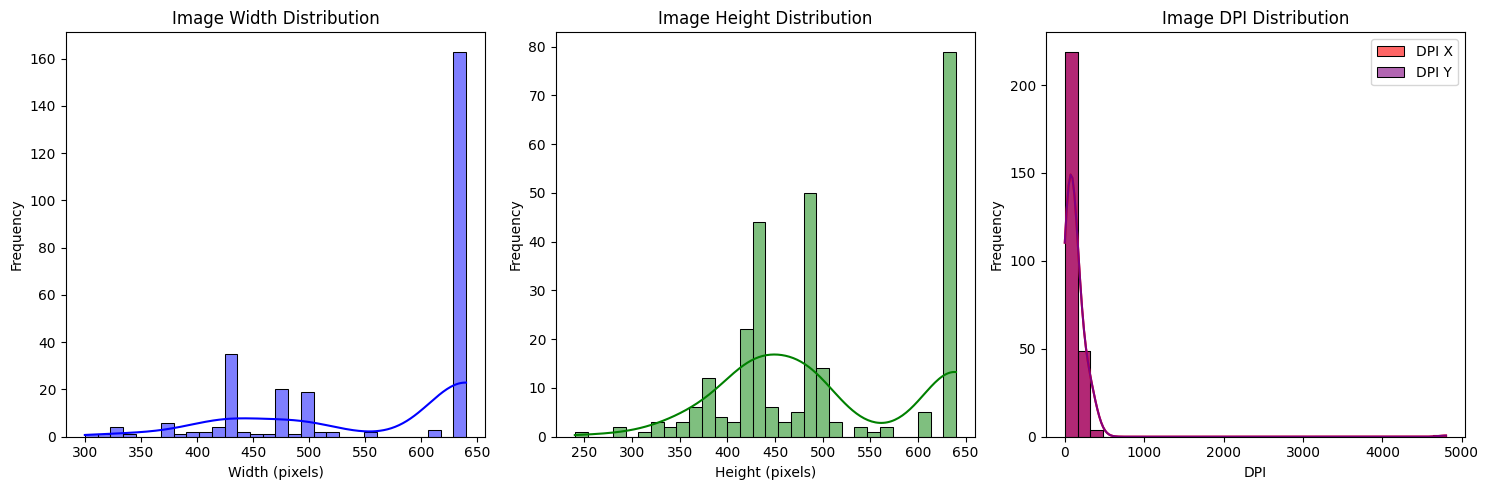

In [6]:
widths, heights = np.array(widths), np.array(heights)
dpi_x, dpi_y = zip(*resolutions)

min_size = (np.min(widths), np.min(heights))
max_size = (np.max(widths), np.max(heights))
avg_size = (np.mean(widths), np.mean(heights))
format_counts = Counter(formats)

min_dpi = (np.min(dpi_x), np.min(dpi_y))
max_dpi = (np.max(dpi_x), np.max(dpi_y)) 
avg_dpi = (np.mean(dpi_x), np.mean(dpi_y)) 

# Plot distributions
plt.figure(figsize=(15, 5))

# Width distribution
plt.subplot(1, 3, 1)
sns.histplot(widths, bins=30, kde=True, color="blue")
plt.xlabel("Width (pixels)")
plt.ylabel("Frequency")
plt.title("Image Width Distribution")

# Height distribution
plt.subplot(1, 3, 2)
sns.histplot(heights, bins=30, kde=True, color="green")
plt.xlabel("Height (pixels)")
plt.ylabel("Frequency")
plt.title("Image Height Distribution")

# DPI distribution
plt.subplot(1, 3, 3)
sns.histplot(dpi_x, bins=30, kde=True, color="red", label="DPI X", alpha=0.6)
sns.histplot(dpi_y, bins=30, kde=True, color="purple", label="DPI Y", alpha=0.6)
plt.xlabel("DPI")
plt.ylabel("Frequency")
plt.title("Image DPI Distribution")
plt.legend()

# Show plots
plt.tight_layout()
plt.show()


##### After the manual checkig fo rany incorrect labels and after the removal of images that have very low portion of body part, meaning; with them the pose cannot be identified, the class imbalace were checked.

C:\Users\USER\AppData\Local\Temp\ipykernel_24808\2081736955.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=list(label_counts.keys()), y=list(label_counts.values()), palette="viridis")


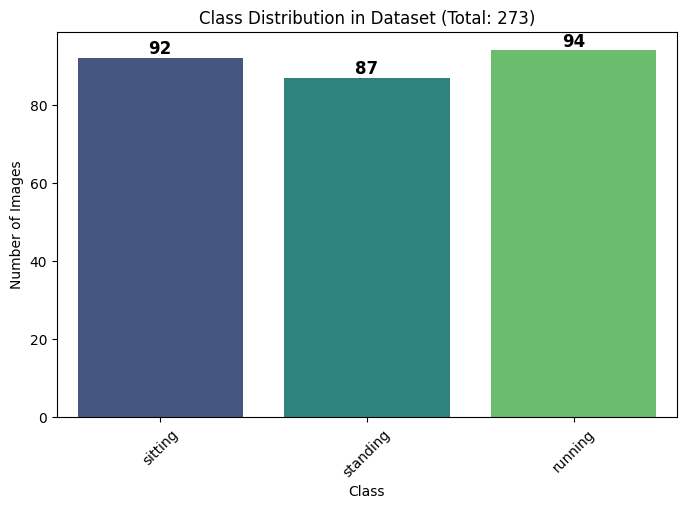

In [7]:
#check class balance and distribution

image_folder = "images"

labels = []
for filename in os.listdir(image_folder):
    label = filename.split("_")[-1].split(".")[0]
    labels.append(label)

label_counts = Counter(labels)
total_images = sum(label_counts.values())

plt.figure(figsize=(8, 5))
ax = sns.barplot(x=list(label_counts.keys()), y=list(label_counts.values()), palette="viridis")

# Annotate each bar with the count
for p in ax.patches:
    ax.annotate(f"{int(p.get_height())}", 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=12, fontweight="bold", color="black")

# Display total count
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title(f"Class Distribution in Dataset (Total: {total_images})")
plt.xticks(rotation=45)
plt.show()



#### CNN and FNN models

This compares the cnn and fnn models with original and removed bacjground images. 

In [ ]:
import torch
import torch.nn as nn
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix


Using device: cpu

=== Processing Original Images ===


C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



=== Training CNN on Original Images ===


Epoch 1/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.09it/s]


Epoch 1/20:
Train Loss: 1.2894, Train Acc: 31.41%
Val Loss: 1.0401, Val Acc: 47.50%


Epoch 2/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.21it/s]


Epoch 2/20:
Train Loss: 0.9799, Train Acc: 53.93%
Val Loss: 1.0303, Val Acc: 52.50%


Epoch 3/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.30it/s]


Epoch 3/20:
Train Loss: 0.8038, Train Acc: 65.45%
Val Loss: 1.0284, Val Acc: 60.00%


Epoch 4/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.30it/s]


Epoch 4/20:
Train Loss: 0.6078, Train Acc: 80.63%
Val Loss: 1.0362, Val Acc: 47.50%


Epoch 5/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.36it/s]


Epoch 5/20:
Train Loss: 0.5067, Train Acc: 83.25%
Val Loss: 1.0604, Val Acc: 42.50%


Epoch 6/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.27it/s]


Epoch 6/20:
Train Loss: 0.3202, Train Acc: 93.72%
Val Loss: 1.2101, Val Acc: 35.00%


Epoch 7/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.31it/s]


Epoch 7/20:
Train Loss: 0.2130, Train Acc: 96.86%
Val Loss: 1.2201, Val Acc: 40.00%


Epoch 8/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.34it/s]


Epoch 8/20:
Train Loss: 0.1532, Train Acc: 99.48%
Val Loss: 1.0999, Val Acc: 27.50%
Early stopping triggered after 8 epochs


Testing: 100%|██████████| 2/2 [00:00<00:00,  2.17it/s]


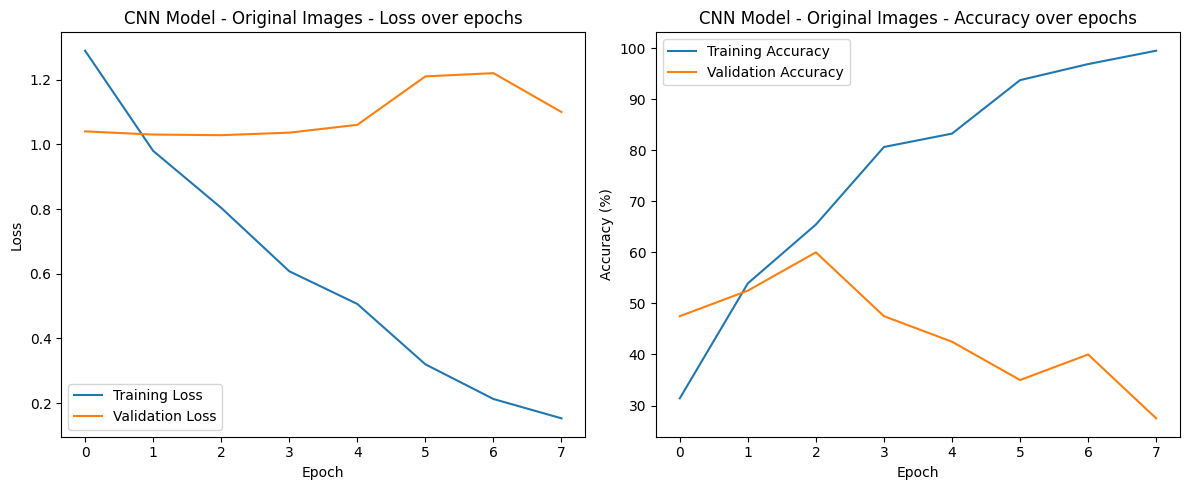

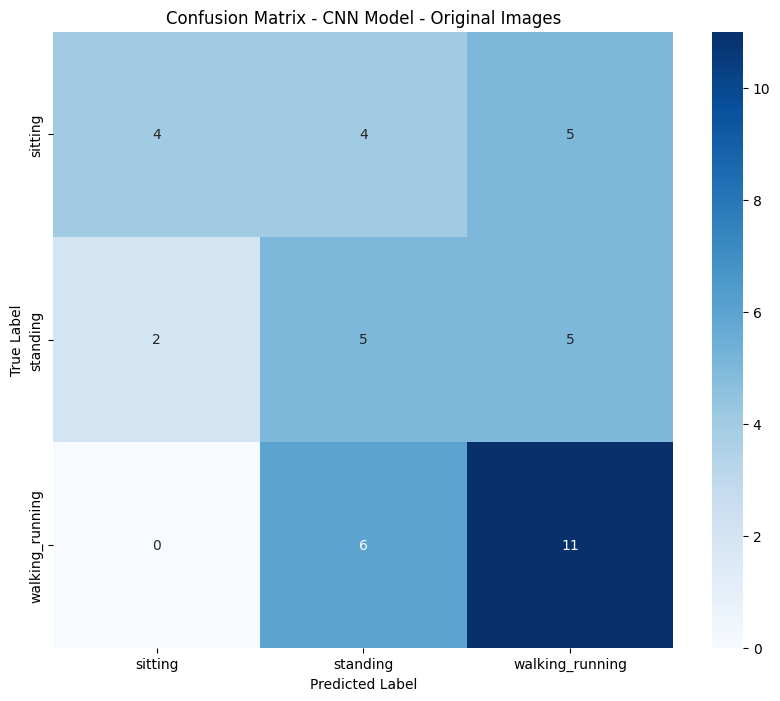

C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



=== Training FNN on Original Images ===


Epoch 1/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  5.59it/s]


Epoch 1/20:
Train Loss: 1.1618, Train Acc: 33.51%
Val Loss: 1.1660, Val Acc: 30.00%


Epoch 2/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  6.14it/s]


Epoch 2/20:
Train Loss: 1.1142, Train Acc: 42.41%
Val Loss: 1.1110, Val Acc: 30.00%


Epoch 3/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  6.01it/s]


Epoch 3/20:
Train Loss: 1.0642, Train Acc: 42.41%
Val Loss: 1.1124, Val Acc: 42.50%


Epoch 4/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  6.41it/s]


Epoch 4/20:
Train Loss: 1.0534, Train Acc: 47.64%
Val Loss: 1.1296, Val Acc: 40.00%


Epoch 5/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  6.19it/s]


Epoch 5/20:
Train Loss: 0.9768, Train Acc: 49.74%
Val Loss: 1.1286, Val Acc: 45.00%


Epoch 6/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  5.01it/s]


Epoch 6/20:
Train Loss: 0.9781, Train Acc: 51.83%
Val Loss: 1.1310, Val Acc: 40.00%


Epoch 7/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  4.17it/s]


Epoch 7/20:
Train Loss: 0.9625, Train Acc: 53.93%
Val Loss: 1.1529, Val Acc: 37.50%
Early stopping triggered after 7 epochs


Testing: 100%|██████████| 2/2 [00:00<00:00,  6.35it/s]


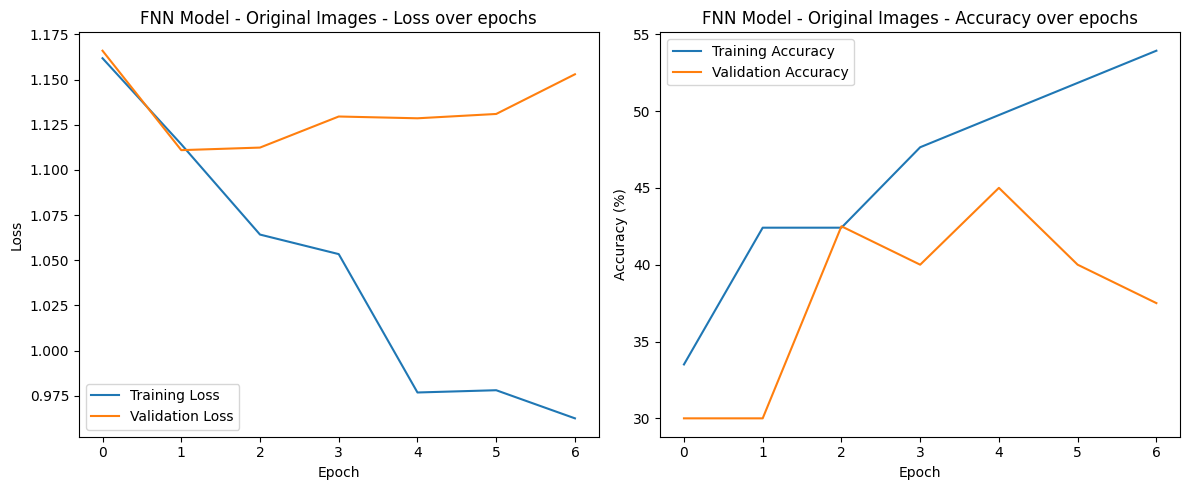

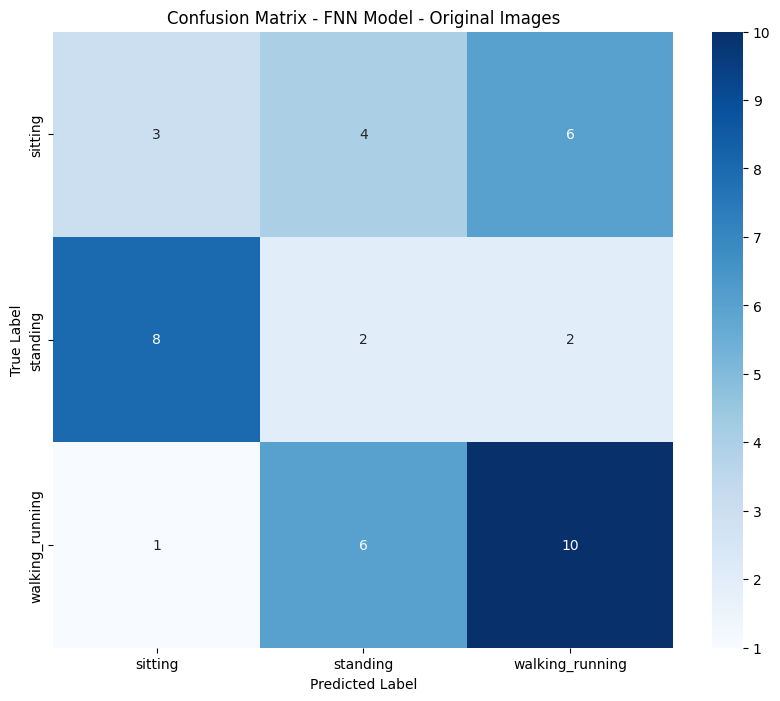


=== Processing Background Removed Images ===


C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



=== Training CNN on Background Removed Images ===


Epoch 1/20 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.24it/s]


Epoch 1/20:
Train Loss: 1.2259, Train Acc: 34.03%
Val Loss: 1.1176, Val Acc: 20.00%


Epoch 2/20 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.46it/s]


Epoch 2/20:
Train Loss: 0.9679, Train Acc: 56.02%
Val Loss: 1.1576, Val Acc: 20.00%


Epoch 3/20 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.36it/s]


Epoch 3/20:
Train Loss: 0.8414, Train Acc: 62.30%
Val Loss: 1.3681, Val Acc: 20.00%


Epoch 4/20 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.23it/s]


Epoch 4/20:
Train Loss: 0.7445, Train Acc: 71.73%
Val Loss: 1.4307, Val Acc: 20.00%


Epoch 5/20 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.34it/s]


Epoch 5/20:
Train Loss: 0.5197, Train Acc: 85.86%
Val Loss: 1.3412, Val Acc: 22.50%


Epoch 6/20 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.30it/s]


Epoch 6/20:
Train Loss: 0.4285, Train Acc: 91.10%
Val Loss: 1.3265, Val Acc: 27.50%
Early stopping triggered after 6 epochs


Testing: 100%|██████████| 2/2 [00:01<00:00,  1.25it/s]


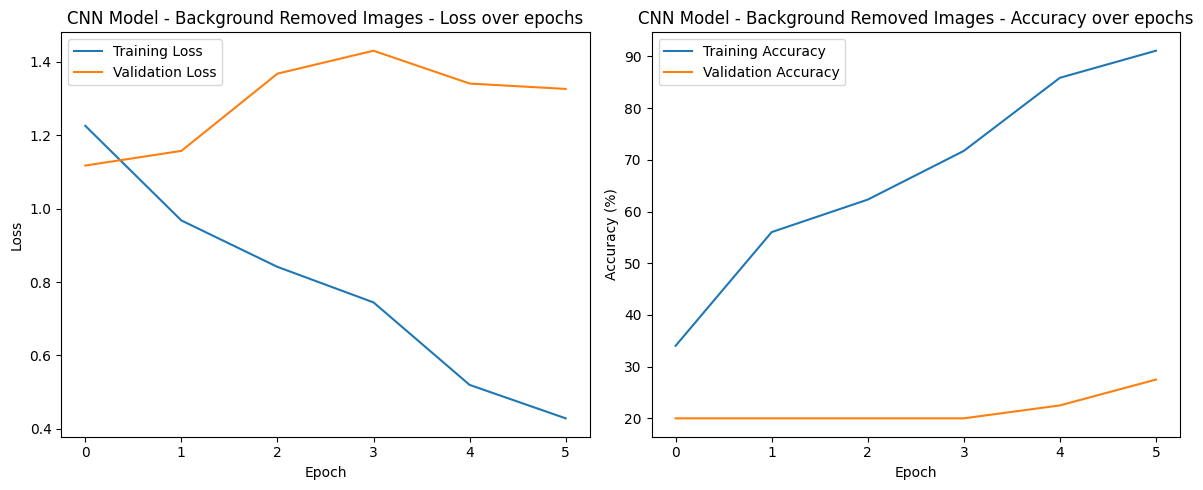

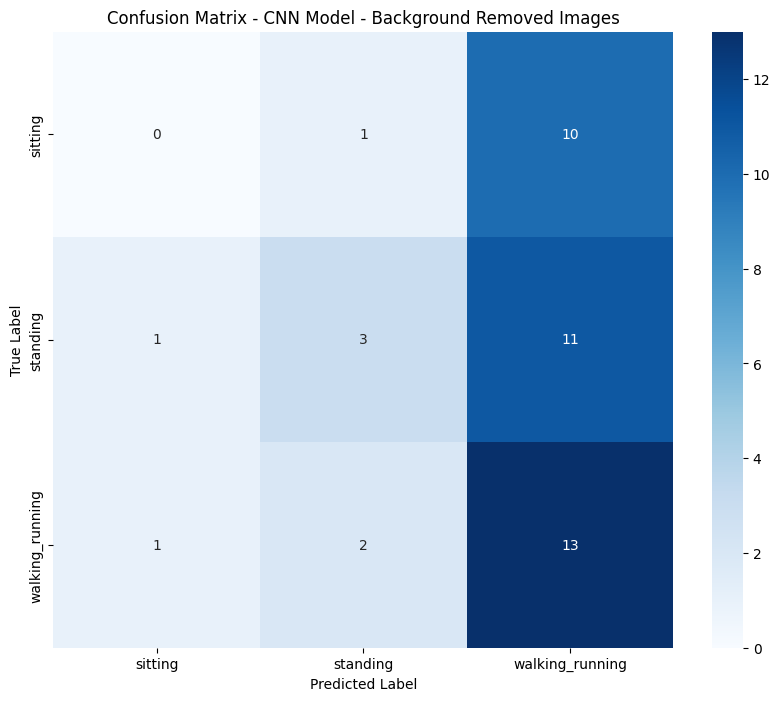

C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



=== Training FNN on Background Removed Images ===


Epoch 1/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  3.04it/s]


Epoch 1/20:
Train Loss: 1.1150, Train Acc: 40.31%
Val Loss: 1.8533, Val Acc: 20.00%


Epoch 2/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  3.31it/s]


Epoch 2/20:
Train Loss: 1.0377, Train Acc: 47.64%
Val Loss: 1.4749, Val Acc: 20.00%


Epoch 3/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.71it/s]


Epoch 3/20:
Train Loss: 1.0099, Train Acc: 47.12%
Val Loss: 1.3044, Val Acc: 20.00%


Epoch 4/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  3.11it/s]


Epoch 4/20:
Train Loss: 1.0266, Train Acc: 45.55%
Val Loss: 1.2248, Val Acc: 22.50%


Epoch 5/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  3.12it/s]


Epoch 5/20:
Train Loss: 0.9641, Train Acc: 53.40%
Val Loss: 1.1688, Val Acc: 27.50%


Epoch 6/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]


Epoch 6/20:
Train Loss: 0.9940, Train Acc: 52.88%
Val Loss: 1.1348, Val Acc: 30.00%


Epoch 7/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  3.23it/s]


Epoch 7/20:
Train Loss: 0.9144, Train Acc: 54.97%
Val Loss: 1.0813, Val Acc: 32.50%


Epoch 8/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  3.16it/s]


Epoch 8/20:
Train Loss: 0.9064, Train Acc: 60.21%
Val Loss: 1.0679, Val Acc: 37.50%


Epoch 9/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  3.24it/s]


Epoch 9/20:
Train Loss: 0.9099, Train Acc: 60.73%
Val Loss: 1.0465, Val Acc: 40.00%


Epoch 10/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.72it/s]


Epoch 10/20:
Train Loss: 0.8489, Train Acc: 59.16%
Val Loss: 1.0183, Val Acc: 50.00%


Epoch 11/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.99it/s]


Epoch 11/20:
Train Loss: 0.8031, Train Acc: 65.97%
Val Loss: 1.0640, Val Acc: 52.50%


Epoch 12/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  3.30it/s]


Epoch 12/20:
Train Loss: 0.8039, Train Acc: 66.49%
Val Loss: 1.0791, Val Acc: 45.00%


Epoch 13/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.92it/s]


Epoch 13/20:
Train Loss: 0.7314, Train Acc: 69.63%
Val Loss: 1.0894, Val Acc: 40.00%


Epoch 14/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  3.23it/s]


Epoch 14/20:
Train Loss: 0.6504, Train Acc: 78.53%
Val Loss: 1.0918, Val Acc: 42.50%


Epoch 15/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.96it/s]


Epoch 15/20:
Train Loss: 0.6514, Train Acc: 77.49%
Val Loss: 1.1495, Val Acc: 42.50%
Early stopping triggered after 15 epochs


Testing: 100%|██████████| 2/2 [00:00<00:00,  3.34it/s]


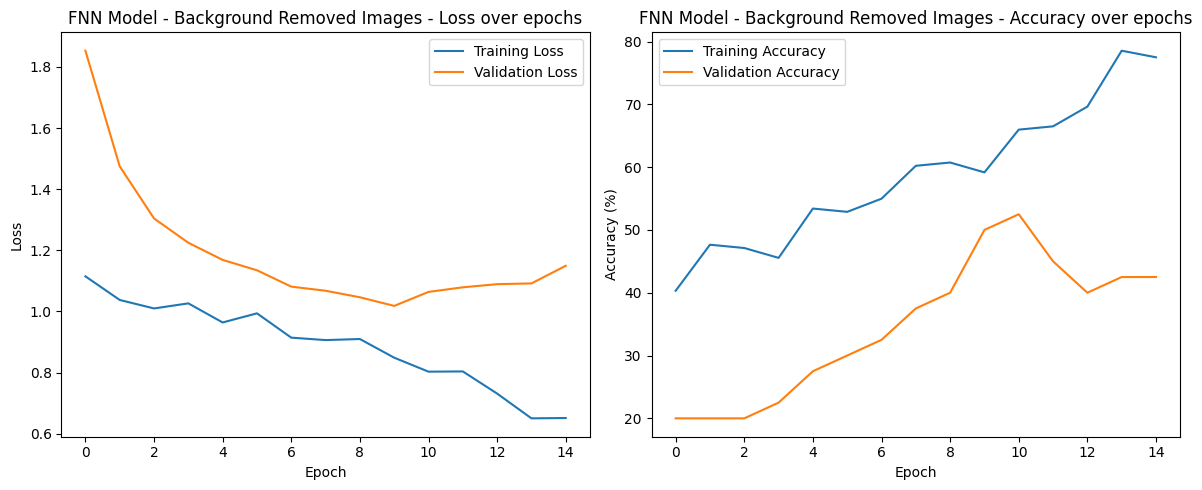

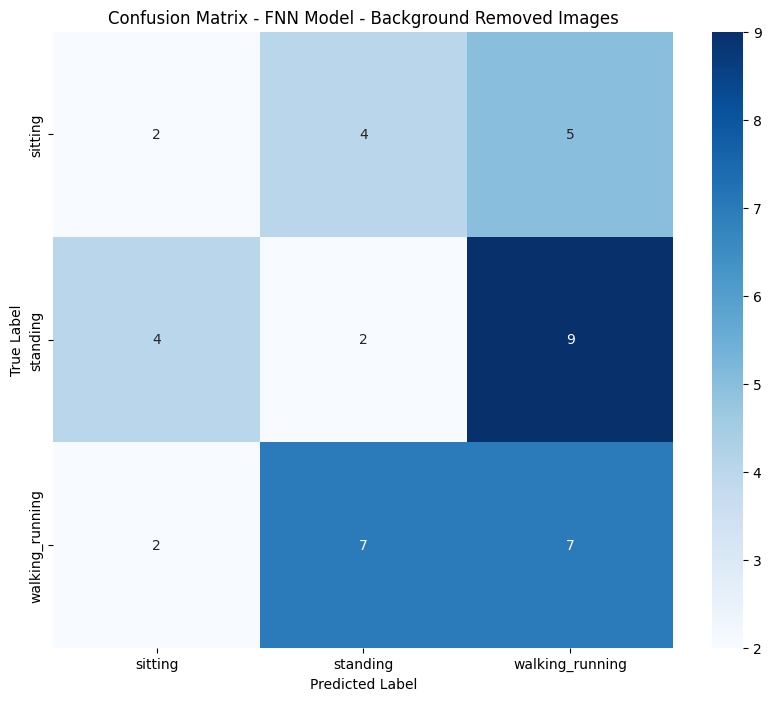


=== Final Comparison ===

Original Images:
CNN - Test Loss: 1.1948, Test Accuracy: 47.62%
FNN - Test Loss: 1.1090, Test Accuracy: 35.71%

Background Removed Images:
CNN - Test Loss: 1.1850, Test Accuracy: 38.10%
FNN - Test Loss: 1.4482, Test Accuracy: 26.19%


In [ ]:
def cnn_base(num_classes=3):
    model = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=3, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
     
        nn.Conv2d(32, 64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),

        nn.Conv2d(64, 128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),

        nn.Conv2d(128, 256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        
        # Flatten
        nn.Flatten(),
        
        # Fully Connected Layers
        nn.Linear(256 * 14 * 14, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Dropout(0.5),
        
        nn.Linear(512, 256),
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.Dropout(0.3),
        
        nn.Linear(256, num_classes)
    )
    return model

def fnn_base(input_size, num_classes=3):
    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(input_size, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Dropout(0.5),
        
        nn.Linear(512, 256),
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.Dropout(0.3),
        
        nn.Linear(256, 128),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.Dropout(0.2),
        
        nn.Linear(128, num_classes)
    )
    return model

def train_model(model, train_loader, val_loader, test_loader, criterion, optimizer, num_epochs, device, patience=5):
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=2, verbose=True
    )
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Training'):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Validation'):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_loss = val_loss / len(val_loader)
        val_acc = 100 * correct / total
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        scheduler.step(val_loss)
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Early stopping triggered after {epoch+1} epochs')
                model.load_state_dict(best_model_state)
                break
    
    # Test the model
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc='Testing'):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    test_loss = test_loss / len(test_loader)
    test_acc = 100 * correct / total
    
    cm = confusion_matrix(all_labels, all_preds)
    class_report = classification_report(all_labels, all_preds, 
                                      target_names=['sitting', 'standing', 'walking_running'])
    
    return train_losses, val_losses, train_accs, val_accs, test_loss, test_acc, cm, class_report

def plot_metrics(train_losses, val_losses, train_accs, val_accs, model_name, dataset_name):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title(f'{model_name} - {dataset_name} - Loss over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.title(f'{model_name} - {dataset_name} - Accuracy over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(cm, model_name, dataset_name):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['sitting', 'standing', 'walking_running'],
                yticklabels=['sitting', 'standing', 'walking_running'])
    plt.title(f'Confusion Matrix - {model_name} - {dataset_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Set parameters
batch_size = 32
num_epochs = 20
learning_rate = 0.001
patience = 5

# Create transforms for RGB images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],  # Standard normalization
                        std=[0.5, 0.5, 0.5])
])

# Define datasets to compare
datasets_to_compare = [
    ('organized_images', 'Original Images'),
    ('organized_images_br', 'Background Removed Images')
]

# Initialize results storage
results = {}

# Train and evaluate models for each dataset
for dataset_path, dataset_name in datasets_to_compare:
    print(f"\n=== Processing {dataset_name} ===")
    
    # Create dataset
    dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
    
    # Split dataset
    total_size = len(dataset)
    train_size = int(0.7 * total_size)
    val_size = int(0.15 * total_size)
    test_size = total_size - train_size - val_size
    
    train_dataset, val_dataset, test_dataset = random_split(
        dataset, [train_size, val_size, test_size]
    )
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Initialize models
    cnn_model = cnn_base(num_classes=3).to(device)
    fnn_model = fnn_base(input_size=224*224*3, num_classes=3).to(device)
    
    # Loss function
    criterion = nn.CrossEntropyLoss()
    
    # Train and evaluate CNN
    print(f"\n=== Training CNN on {dataset_name} ===")
    cnn_optimizer = optim.Adam(cnn_model.parameters(), lr=learning_rate)
    cnn_results = train_model(
        cnn_model, train_loader, val_loader, test_loader, 
        criterion, cnn_optimizer, num_epochs, device, patience
    )
    
    # Plot CNN metrics
    plot_metrics(
        cnn_results[0], cnn_results[1], cnn_results[2], cnn_results[3],
        'CNN Model', dataset_name
    )
    
    # Plot CNN confusion matrix
    plot_confusion_matrix(cnn_results[6], 'CNN Model', dataset_name)
    
    # Train and evaluate FNN
    print(f"\n=== Training FNN on {dataset_name} ===")
    fnn_optimizer = optim.Adam(fnn_model.parameters(), lr=learning_rate)
    fnn_results = train_model(
        fnn_model, train_loader, val_loader, test_loader,
        criterion, fnn_optimizer, num_epochs, device, patience
    )
    
    # Plot FNN metrics
    plot_metrics(
        fnn_results[0], fnn_results[1], fnn_results[2], fnn_results[3],
        'FNN Model', dataset_name
    )
    
    # Plot FNN confusion matrix
    plot_confusion_matrix(fnn_results[6], 'FNN Model', dataset_name)
    
    # Store results
    results[dataset_name] = {
        'CNN': {
            'test_loss': cnn_results[4],
            'test_acc': cnn_results[5],
            'confusion_matrix': cnn_results[6],
            'classification_report': cnn_results[7]
        },
        'FNN': {
            'test_loss': fnn_results[4],
            'test_acc': fnn_results[5],
            'confusion_matrix': fnn_results[6],
            'classification_report': fnn_results[7]
        }
    }

# Print final comparison
print("\n=== Final Comparison ===")
for dataset_name in results:
    print(f"\n{dataset_name}:")
    print("CNN - Test Loss: {:.4f}, Test Accuracy: {:.2f}%".format(
        results[dataset_name]['CNN']['test_loss'],
        results[dataset_name]['CNN']['test_acc']
    ))
    print("FNN - Test Loss: {:.4f}, Test Accuracy: {:.2f}%".format(
        results[dataset_name]['FNN']['test_loss'],
        results[dataset_name]['FNN']['test_acc']
    ))

### T test for fnn and cnn
to compare the cnn and fnn models, the t test is performed by using the test accuracies. they were recorded by running independant runs (5)

In [7]:
from scipy import stats

In [37]:
# Initialize results storage
test_results = {
    'Original Images': {
        'CNN': {'test_acc': [results['Original Images']['CNN']['test_acc']]},
        'FNN': {'test_acc': [results['Original Images']['FNN']['test_acc']]}
    },
    'Background Removed Images': {
        'CNN': {'test_acc': [results['Background Removed Images']['CNN']['test_acc']]},
        'FNN': {'test_acc': [results['Background Removed Images']['FNN']['test_acc']]}
    }
}

for i in range(5):
# Train and evaluate models for each dataset
    for dataset_path, dataset_name in datasets_to_compare:
        print(f"\n=== Processing {dataset_name} ===")
        
        # Create dataset
        dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
        
        # Split dataset
        total_size = len(dataset)
        train_size = int(0.7 * total_size)
        val_size = int(0.15 * total_size)
        test_size = total_size - train_size - val_size
        
        train_dataset, val_dataset, test_dataset = random_split(
            dataset, [train_size, val_size, test_size]
        )
        
        # Create data loaders
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        
        # Initialize models
        cnn_model = cnn_base(num_classes=3).to(device)
        fnn_model = fnn_base(input_size=224*224*3, num_classes=3).to(device)
        
        # Loss function
        criterion = nn.CrossEntropyLoss()
        
        # Train and evaluate CNN
        print(f"\n=== Training CNN on {dataset_name} ===")
        cnn_optimizer = optim.Adam(cnn_model.parameters(), lr=learning_rate)
        cnn_results = train_model(
            cnn_model, train_loader, val_loader, test_loader, 
            criterion, cnn_optimizer, num_epochs, device, patience
        )
        
        
        # Train and evaluate FNN
        print(f"\n=== Training FNN on {dataset_name} ===")
        fnn_optimizer = optim.Adam(fnn_model.parameters(), lr=learning_rate)
        fnn_results = train_model(
            fnn_model, train_loader, val_loader, test_loader,
            criterion, fnn_optimizer, num_epochs, device, patience
        )
        # Store results
        test_results[dataset_name]['CNN']['test_acc'].append(cnn_results[5])
        test_results[dataset_name]['FNN']['test_acc'].append(fnn_results[5])


=== Processing Original Images ===


C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



=== Training CNN on Original Images ===


Epoch 1/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.58it/s]


Epoch 1/20:
Train Loss: 1.1939, Train Acc: 41.36%
Val Loss: 1.2368, Val Acc: 30.00%


Epoch 2/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.51it/s]


Epoch 2/20:
Train Loss: 0.8501, Train Acc: 60.73%
Val Loss: 1.3703, Val Acc: 30.00%


Epoch 3/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.62it/s]


Epoch 3/20:
Train Loss: 0.7129, Train Acc: 75.92%
Val Loss: 1.3714, Val Acc: 30.00%


Epoch 4/20 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.35it/s]


Epoch 4/20:
Train Loss: 0.5587, Train Acc: 82.20%
Val Loss: 1.5437, Val Acc: 32.50%


Epoch 5/20 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.66it/s]


Epoch 5/20:
Train Loss: 0.3953, Train Acc: 88.48%
Val Loss: 1.6183, Val Acc: 30.00%


Epoch 6/20 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.62it/s]


Epoch 6/20:
Train Loss: 0.3106, Train Acc: 94.76%
Val Loss: 1.5339, Val Acc: 35.00%
Early stopping triggered after 6 epochs


Testing: 100%|██████████| 2/2 [00:01<00:00,  1.34it/s]
C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



=== Training FNN on Original Images ===


Epoch 1/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  5.04it/s]


Epoch 1/20:
Train Loss: 1.2231, Train Acc: 27.23%
Val Loss: 1.2393, Val Acc: 22.50%


Epoch 2/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  4.65it/s]


Epoch 2/20:
Train Loss: 1.0752, Train Acc: 45.03%
Val Loss: 1.3587, Val Acc: 27.50%


Epoch 3/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  4.99it/s]


Epoch 3/20:
Train Loss: 1.0074, Train Acc: 53.40%
Val Loss: 1.3284, Val Acc: 22.50%


Epoch 4/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  4.73it/s]


Epoch 4/20:
Train Loss: 0.9390, Train Acc: 57.59%
Val Loss: 1.3050, Val Acc: 27.50%


Epoch 5/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  4.61it/s]


Epoch 5/20:
Train Loss: 0.9589, Train Acc: 51.83%
Val Loss: 1.2894, Val Acc: 22.50%


Epoch 6/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  4.05it/s]


Epoch 6/20:
Train Loss: 0.9560, Train Acc: 55.50%
Val Loss: 1.2941, Val Acc: 25.00%
Early stopping triggered after 6 epochs


Testing: 100%|██████████| 2/2 [00:00<00:00,  4.89it/s]



=== Processing Background Removed Images ===


C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



=== Training CNN on Background Removed Images ===


Epoch 1/20 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.92it/s]


Epoch 1/20:
Train Loss: 1.1911, Train Acc: 34.55%
Val Loss: 1.2231, Val Acc: 27.50%


Epoch 2/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.12it/s]


Epoch 2/20:
Train Loss: 0.9022, Train Acc: 58.64%
Val Loss: 1.4555, Val Acc: 27.50%


Epoch 3/20 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.72it/s]


Epoch 3/20:
Train Loss: 0.7849, Train Acc: 64.40%
Val Loss: 1.3822, Val Acc: 27.50%


Epoch 4/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.23it/s]


Epoch 4/20:
Train Loss: 0.6655, Train Acc: 74.35%
Val Loss: 1.3318, Val Acc: 27.50%


Epoch 5/20 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.95it/s]


Epoch 5/20:
Train Loss: 0.5139, Train Acc: 79.58%
Val Loss: 1.2893, Val Acc: 32.50%


Epoch 6/20 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.73it/s]


Epoch 6/20:
Train Loss: 0.4532, Train Acc: 86.39%
Val Loss: 1.2081, Val Acc: 37.50%


Epoch 7/20 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.86it/s]


Epoch 7/20:
Train Loss: 0.3350, Train Acc: 92.67%
Val Loss: 1.2929, Val Acc: 32.50%


Epoch 8/20 - Validation: 100%|██████████| 2/2 [02:36<00:00, 78.15s/it]


Epoch 8/20:
Train Loss: 0.2800, Train Acc: 93.72%
Val Loss: 1.3691, Val Acc: 30.00%


Epoch 9/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.52it/s]


Epoch 9/20:
Train Loss: 0.1901, Train Acc: 96.86%
Val Loss: 1.4090, Val Acc: 30.00%


Epoch 10/20 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.99it/s]


Epoch 10/20:
Train Loss: 0.1608, Train Acc: 96.86%
Val Loss: 1.3235, Val Acc: 37.50%


Epoch 11/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.64it/s]


Epoch 11/20:
Train Loss: 0.1333, Train Acc: 99.48%
Val Loss: 1.2059, Val Acc: 37.50%


Epoch 12/20 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.85it/s]


Epoch 12/20:
Train Loss: 0.1158, Train Acc: 98.43%
Val Loss: 1.2289, Val Acc: 35.00%


Epoch 13/20 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.60it/s]


Epoch 13/20:
Train Loss: 0.0883, Train Acc: 98.95%
Val Loss: 1.2846, Val Acc: 35.00%


Epoch 14/20 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.79it/s]


Epoch 14/20:
Train Loss: 0.0964, Train Acc: 98.43%
Val Loss: 1.3673, Val Acc: 32.50%


Epoch 15/20 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.83it/s]


Epoch 15/20:
Train Loss: 0.0722, Train Acc: 99.48%
Val Loss: 1.4210, Val Acc: 40.00%


Epoch 16/20 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.81it/s]


Epoch 16/20:
Train Loss: 0.0733, Train Acc: 98.95%
Val Loss: 1.4426, Val Acc: 40.00%
Early stopping triggered after 16 epochs


Testing: 100%|██████████| 2/2 [00:00<00:00,  2.20it/s]
C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



=== Training FNN on Background Removed Images ===


Epoch 1/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  6.30it/s]


Epoch 1/20:
Train Loss: 1.1545, Train Acc: 31.41%
Val Loss: 1.4574, Val Acc: 22.50%


Epoch 2/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  6.19it/s]


Epoch 2/20:
Train Loss: 1.1328, Train Acc: 41.36%
Val Loss: 1.6911, Val Acc: 25.00%


Epoch 3/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  5.75it/s]


Epoch 3/20:
Train Loss: 1.0350, Train Acc: 48.17%
Val Loss: 1.5296, Val Acc: 20.00%


Epoch 4/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  6.06it/s]


Epoch 4/20:
Train Loss: 1.0032, Train Acc: 47.64%
Val Loss: 1.4461, Val Acc: 22.50%


Epoch 5/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  6.42it/s]


Epoch 5/20:
Train Loss: 0.9423, Train Acc: 58.12%
Val Loss: 1.3061, Val Acc: 25.00%


Epoch 6/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  5.69it/s]


Epoch 6/20:
Train Loss: 0.9300, Train Acc: 58.64%
Val Loss: 1.2780, Val Acc: 30.00%


Epoch 7/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  4.92it/s]


Epoch 7/20:
Train Loss: 0.8920, Train Acc: 62.83%
Val Loss: 1.2559, Val Acc: 32.50%


Epoch 8/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  5.58it/s]


Epoch 8/20:
Train Loss: 0.8676, Train Acc: 60.21%
Val Loss: 1.2137, Val Acc: 37.50%


Epoch 9/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  4.06it/s]


Epoch 9/20:
Train Loss: 0.8313, Train Acc: 64.40%
Val Loss: 1.2212, Val Acc: 40.00%


Epoch 10/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  6.43it/s]


Epoch 10/20:
Train Loss: 0.7976, Train Acc: 65.45%
Val Loss: 1.2401, Val Acc: 45.00%


Epoch 11/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  4.48it/s]


Epoch 11/20:
Train Loss: 0.7362, Train Acc: 68.06%
Val Loss: 1.2106, Val Acc: 42.50%


Epoch 12/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  5.95it/s]


Epoch 12/20:
Train Loss: 0.6708, Train Acc: 73.30%
Val Loss: 1.2213, Val Acc: 42.50%


Epoch 13/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  5.94it/s]


Epoch 13/20:
Train Loss: 0.6017, Train Acc: 75.92%
Val Loss: 1.3632, Val Acc: 35.00%


Epoch 14/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  5.52it/s]


Epoch 14/20:
Train Loss: 0.5757, Train Acc: 75.39%
Val Loss: 1.7430, Val Acc: 35.00%


Epoch 15/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  6.71it/s]


Epoch 15/20:
Train Loss: 0.5064, Train Acc: 82.72%
Val Loss: 1.5783, Val Acc: 32.50%


Epoch 16/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  6.42it/s]


Epoch 16/20:
Train Loss: 0.5376, Train Acc: 78.01%
Val Loss: 1.4603, Val Acc: 37.50%
Early stopping triggered after 16 epochs


Testing: 100%|██████████| 2/2 [00:00<00:00,  6.86it/s]



=== Processing Original Images ===


C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



=== Training CNN on Original Images ===


Epoch 1/20 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.62it/s]


Epoch 1/20:
Train Loss: 1.2087, Train Acc: 30.89%
Val Loss: 1.1422, Val Acc: 30.00%


Epoch 2/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.06it/s]


Epoch 2/20:
Train Loss: 0.9050, Train Acc: 59.69%
Val Loss: 1.1204, Val Acc: 30.00%


Epoch 3/20 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.68it/s]


Epoch 3/20:
Train Loss: 0.7371, Train Acc: 72.77%
Val Loss: 1.1041, Val Acc: 35.00%


Epoch 4/20 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.40it/s]


Epoch 4/20:
Train Loss: 0.5235, Train Acc: 82.20%
Val Loss: 1.1620, Val Acc: 30.00%


Epoch 5/20 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.96it/s]


Epoch 5/20:
Train Loss: 0.4062, Train Acc: 91.10%
Val Loss: 1.1081, Val Acc: 42.50%


Epoch 6/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.08it/s]


Epoch 6/20:
Train Loss: 0.2609, Train Acc: 94.76%
Val Loss: 1.1153, Val Acc: 40.00%


Epoch 7/20 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.71it/s]


Epoch 7/20:
Train Loss: 0.1970, Train Acc: 97.91%
Val Loss: 1.1336, Val Acc: 42.50%


Epoch 8/20 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.54it/s]


Epoch 8/20:
Train Loss: 0.1609, Train Acc: 97.38%
Val Loss: 1.1292, Val Acc: 47.50%
Early stopping triggered after 8 epochs


Testing: 100%|██████████| 2/2 [00:01<00:00,  1.44it/s]
C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



=== Training FNN on Original Images ===


Epoch 1/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  3.57it/s]


Epoch 1/20:
Train Loss: 1.1656, Train Acc: 31.41%
Val Loss: 1.1675, Val Acc: 32.50%


Epoch 2/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  5.44it/s]


Epoch 2/20:
Train Loss: 1.0493, Train Acc: 48.17%
Val Loss: 1.1886, Val Acc: 32.50%


Epoch 3/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  5.13it/s]


Epoch 3/20:
Train Loss: 1.0017, Train Acc: 50.79%
Val Loss: 1.1492, Val Acc: 37.50%


Epoch 4/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  5.08it/s]


Epoch 4/20:
Train Loss: 0.9847, Train Acc: 55.50%
Val Loss: 1.1338, Val Acc: 40.00%


Epoch 5/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  4.29it/s]


Epoch 5/20:
Train Loss: 0.9928, Train Acc: 48.17%
Val Loss: 1.1464, Val Acc: 47.50%


Epoch 6/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  5.14it/s]


Epoch 6/20:
Train Loss: 0.9257, Train Acc: 59.69%
Val Loss: 1.1651, Val Acc: 42.50%


Epoch 7/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  5.04it/s]


Epoch 7/20:
Train Loss: 0.9260, Train Acc: 58.12%
Val Loss: 1.1637, Val Acc: 45.00%


Epoch 8/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  4.96it/s]


Epoch 8/20:
Train Loss: 0.8979, Train Acc: 59.16%
Val Loss: 1.1532, Val Acc: 50.00%


Epoch 9/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  4.92it/s]


Epoch 9/20:
Train Loss: 0.8841, Train Acc: 61.26%
Val Loss: 1.1729, Val Acc: 47.50%
Early stopping triggered after 9 epochs


Testing: 100%|██████████| 2/2 [00:00<00:00,  4.87it/s]



=== Processing Background Removed Images ===


C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



=== Training CNN on Background Removed Images ===


Epoch 1/20 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.95it/s]


Epoch 1/20:
Train Loss: 1.2380, Train Acc: 25.13%
Val Loss: 1.0953, Val Acc: 37.50%


Epoch 2/20 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.80it/s]


Epoch 2/20:
Train Loss: 1.0074, Train Acc: 54.45%
Val Loss: 1.1716, Val Acc: 37.50%


Epoch 3/20 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.86it/s]


Epoch 3/20:
Train Loss: 0.8791, Train Acc: 62.83%
Val Loss: 1.2115, Val Acc: 30.00%


Epoch 4/20 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.82it/s]


Epoch 4/20:
Train Loss: 0.7602, Train Acc: 69.11%
Val Loss: 1.3293, Val Acc: 17.50%


Epoch 5/20 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.80it/s]


Epoch 5/20:
Train Loss: 0.5861, Train Acc: 79.58%
Val Loss: 1.3082, Val Acc: 32.50%


Epoch 6/20 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.78it/s]


Epoch 6/20:
Train Loss: 0.4977, Train Acc: 80.63%
Val Loss: 1.2866, Val Acc: 30.00%
Early stopping triggered after 6 epochs


Testing: 100%|██████████| 2/2 [00:01<00:00,  1.59it/s]
C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _w


=== Training FNN on Background Removed Images ===


Epoch 1/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  6.56it/s]


Epoch 1/20:
Train Loss: 1.2243, Train Acc: 28.80%
Val Loss: 1.0958, Val Acc: 40.00%


Epoch 2/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  4.43it/s]


Epoch 2/20:
Train Loss: 1.0573, Train Acc: 41.88%
Val Loss: 1.2184, Val Acc: 37.50%


Epoch 3/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  6.12it/s]


Epoch 3/20:
Train Loss: 1.1046, Train Acc: 37.70%
Val Loss: 1.2198, Val Acc: 17.50%


Epoch 4/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  6.19it/s]


Epoch 4/20:
Train Loss: 1.0141, Train Acc: 53.40%
Val Loss: 1.2288, Val Acc: 20.00%


Epoch 5/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  5.50it/s]


Epoch 5/20:
Train Loss: 0.9981, Train Acc: 50.26%
Val Loss: 1.1578, Val Acc: 37.50%


Epoch 6/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  6.28it/s]


Epoch 6/20:
Train Loss: 0.9727, Train Acc: 52.88%
Val Loss: 1.1328, Val Acc: 40.00%
Early stopping triggered after 6 epochs


Testing: 100%|██████████| 2/2 [00:00<00:00,  6.25it/s]



=== Processing Original Images ===


C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



=== Training CNN on Original Images ===


Epoch 1/20 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.91it/s]


Epoch 1/20:
Train Loss: 1.2066, Train Acc: 33.51%
Val Loss: 1.0758, Val Acc: 30.00%


Epoch 2/20 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.92it/s]


Epoch 2/20:
Train Loss: 0.9436, Train Acc: 58.12%
Val Loss: 1.1034, Val Acc: 47.50%


Epoch 3/20 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.38it/s]


Epoch 3/20:
Train Loss: 0.7943, Train Acc: 66.49%
Val Loss: 1.1527, Val Acc: 42.50%


Epoch 4/20 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.43it/s]


Epoch 4/20:
Train Loss: 0.6483, Train Acc: 78.53%
Val Loss: 1.2034, Val Acc: 42.50%


Epoch 5/20 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.55it/s]


Epoch 5/20:
Train Loss: 0.5439, Train Acc: 86.39%
Val Loss: 1.1918, Val Acc: 45.00%


Epoch 6/20 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.64it/s]


Epoch 6/20:
Train Loss: 0.3911, Train Acc: 90.05%
Val Loss: 1.1771, Val Acc: 42.50%
Early stopping triggered after 6 epochs


Testing: 100%|██████████| 2/2 [00:01<00:00,  1.72it/s]
C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



=== Training FNN on Original Images ===


Epoch 1/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  4.95it/s]


Epoch 1/20:
Train Loss: 1.1805, Train Acc: 35.60%
Val Loss: 1.0794, Val Acc: 35.00%


Epoch 2/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  4.95it/s]


Epoch 2/20:
Train Loss: 1.0646, Train Acc: 40.31%
Val Loss: 1.0549, Val Acc: 32.50%


Epoch 3/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  5.04it/s]


Epoch 3/20:
Train Loss: 1.0432, Train Acc: 45.03%
Val Loss: 1.0538, Val Acc: 45.00%


Epoch 4/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  4.70it/s]


Epoch 4/20:
Train Loss: 1.0616, Train Acc: 42.93%
Val Loss: 1.0853, Val Acc: 37.50%


Epoch 5/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  5.31it/s]


Epoch 5/20:
Train Loss: 0.9639, Train Acc: 59.69%
Val Loss: 1.1298, Val Acc: 32.50%


Epoch 6/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  4.56it/s]


Epoch 6/20:
Train Loss: 0.9666, Train Acc: 54.97%
Val Loss: 1.1583, Val Acc: 32.50%


Epoch 7/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  4.94it/s]


Epoch 7/20:
Train Loss: 0.9457, Train Acc: 59.16%
Val Loss: 1.1378, Val Acc: 30.00%


Epoch 8/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  5.04it/s]


Epoch 8/20:
Train Loss: 0.9530, Train Acc: 54.97%
Val Loss: 1.1098, Val Acc: 32.50%
Early stopping triggered after 8 epochs


Testing: 100%|██████████| 2/2 [00:00<00:00,  5.64it/s]



=== Processing Background Removed Images ===


C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



=== Training CNN on Background Removed Images ===


Epoch 1/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.19it/s]


Epoch 1/20:
Train Loss: 1.1826, Train Acc: 35.60%
Val Loss: 1.1431, Val Acc: 27.50%


Epoch 2/20 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.98it/s]


Epoch 2/20:
Train Loss: 0.8946, Train Acc: 57.07%
Val Loss: 1.2096, Val Acc: 27.50%


Epoch 3/20 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.69it/s]


Epoch 3/20:
Train Loss: 0.7827, Train Acc: 70.16%
Val Loss: 1.2936, Val Acc: 27.50%


Epoch 4/20 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.92it/s]


Epoch 4/20:
Train Loss: 0.5570, Train Acc: 83.25%
Val Loss: 1.3426, Val Acc: 27.50%


Epoch 5/20 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.74it/s]


Epoch 5/20:
Train Loss: 0.4072, Train Acc: 90.05%
Val Loss: 1.2871, Val Acc: 27.50%


Epoch 6/20 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.91it/s]


Epoch 6/20:
Train Loss: 0.3078, Train Acc: 94.76%
Val Loss: 1.3828, Val Acc: 30.00%
Early stopping triggered after 6 epochs


Testing: 100%|██████████| 2/2 [00:01<00:00,  1.62it/s]
C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _w


=== Training FNN on Background Removed Images ===


Epoch 1/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  6.44it/s]


Epoch 1/20:
Train Loss: 1.1592, Train Acc: 34.55%
Val Loss: 1.6719, Val Acc: 27.50%


Epoch 2/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  5.47it/s]


Epoch 2/20:
Train Loss: 1.0914, Train Acc: 38.22%
Val Loss: 1.5532, Val Acc: 30.00%


Epoch 3/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  5.97it/s]


Epoch 3/20:
Train Loss: 1.0211, Train Acc: 50.26%
Val Loss: 1.4263, Val Acc: 25.00%


Epoch 4/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  6.93it/s]


Epoch 4/20:
Train Loss: 0.9726, Train Acc: 47.64%
Val Loss: 1.3806, Val Acc: 35.00%


Epoch 5/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  6.44it/s]


Epoch 5/20:
Train Loss: 0.9507, Train Acc: 50.26%
Val Loss: 1.3025, Val Acc: 32.50%


Epoch 6/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  6.62it/s]


Epoch 6/20:
Train Loss: 0.9467, Train Acc: 51.31%
Val Loss: 1.2021, Val Acc: 37.50%


Epoch 7/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  6.64it/s]


Epoch 7/20:
Train Loss: 0.8685, Train Acc: 61.78%
Val Loss: 1.1522, Val Acc: 35.00%


Epoch 8/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  4.98it/s]


Epoch 8/20:
Train Loss: 0.8253, Train Acc: 63.87%
Val Loss: 1.1442, Val Acc: 32.50%


Epoch 9/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  6.50it/s]


Epoch 9/20:
Train Loss: 0.7537, Train Acc: 65.45%
Val Loss: 1.1385, Val Acc: 37.50%


Epoch 10/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  6.48it/s]


Epoch 10/20:
Train Loss: 0.7630, Train Acc: 67.02%
Val Loss: 1.1641, Val Acc: 37.50%


Epoch 11/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  6.43it/s]


Epoch 11/20:
Train Loss: 0.6801, Train Acc: 74.35%
Val Loss: 1.1879, Val Acc: 32.50%


Epoch 12/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  6.29it/s]


Epoch 12/20:
Train Loss: 0.6439, Train Acc: 77.49%
Val Loss: 1.1825, Val Acc: 37.50%


Epoch 13/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  4.25it/s]


Epoch 13/20:
Train Loss: 0.5484, Train Acc: 82.72%
Val Loss: 1.1813, Val Acc: 40.00%


Epoch 14/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  5.46it/s]


Epoch 14/20:
Train Loss: 0.5337, Train Acc: 81.68%
Val Loss: 1.1729, Val Acc: 35.00%
Early stopping triggered after 14 epochs


Testing: 100%|██████████| 2/2 [00:00<00:00,  6.95it/s]



=== Processing Original Images ===


C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



=== Training CNN on Original Images ===


Epoch 1/20 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.41it/s]


Epoch 1/20:
Train Loss: 1.2169, Train Acc: 32.46%
Val Loss: 1.1466, Val Acc: 22.50%


Epoch 2/20 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


Epoch 2/20:
Train Loss: 0.8941, Train Acc: 67.02%
Val Loss: 1.2668, Val Acc: 25.00%


Epoch 3/20 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.91it/s]


Epoch 3/20:
Train Loss: 0.7063, Train Acc: 73.82%
Val Loss: 1.4173, Val Acc: 22.50%


Epoch 4/20 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Epoch 4/20:
Train Loss: 0.5542, Train Acc: 83.77%
Val Loss: 1.3485, Val Acc: 30.00%


Epoch 5/20 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.71it/s]


Epoch 5/20:
Train Loss: 0.3817, Train Acc: 92.67%
Val Loss: 1.4623, Val Acc: 22.50%


Epoch 6/20 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.68it/s]


Epoch 6/20:
Train Loss: 0.3017, Train Acc: 96.34%
Val Loss: 1.4638, Val Acc: 25.00%
Early stopping triggered after 6 epochs


Testing: 100%|██████████| 2/2 [00:01<00:00,  1.96it/s]
C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



=== Training FNN on Original Images ===


Epoch 1/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  4.47it/s]


Epoch 1/20:
Train Loss: 1.1463, Train Acc: 39.27%
Val Loss: 1.1433, Val Acc: 37.50%


Epoch 2/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  4.59it/s]


Epoch 2/20:
Train Loss: 1.0340, Train Acc: 48.17%
Val Loss: 1.1626, Val Acc: 30.00%


Epoch 3/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  4.62it/s]


Epoch 3/20:
Train Loss: 1.0101, Train Acc: 48.17%
Val Loss: 1.2020, Val Acc: 22.50%


Epoch 4/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  5.13it/s]


Epoch 4/20:
Train Loss: 0.9904, Train Acc: 50.79%
Val Loss: 1.1896, Val Acc: 30.00%


Epoch 5/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  4.89it/s]


Epoch 5/20:
Train Loss: 0.9626, Train Acc: 54.97%
Val Loss: 1.1658, Val Acc: 27.50%


Epoch 6/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  4.90it/s]


Epoch 6/20:
Train Loss: 0.9280, Train Acc: 54.45%
Val Loss: 1.1533, Val Acc: 27.50%
Early stopping triggered after 6 epochs


Testing: 100%|██████████| 2/2 [00:00<00:00,  4.95it/s]



=== Processing Background Removed Images ===


C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



=== Training CNN on Background Removed Images ===


Epoch 1/20 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.36it/s]


Epoch 1/20:
Train Loss: 1.2070, Train Acc: 35.08%
Val Loss: 1.1597, Val Acc: 37.50%


Epoch 2/20 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.86it/s]


Epoch 2/20:
Train Loss: 0.9824, Train Acc: 55.50%
Val Loss: 1.2339, Val Acc: 37.50%


Epoch 3/20 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.79it/s]


Epoch 3/20:
Train Loss: 0.8124, Train Acc: 69.11%
Val Loss: 1.2299, Val Acc: 37.50%


Epoch 4/20 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.76it/s]


Epoch 4/20:
Train Loss: 0.6363, Train Acc: 76.96%
Val Loss: 1.3625, Val Acc: 37.50%


Epoch 5/20 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.84it/s]


Epoch 5/20:
Train Loss: 0.4625, Train Acc: 86.91%
Val Loss: 1.3123, Val Acc: 37.50%


Epoch 6/20 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.63it/s]


Epoch 6/20:
Train Loss: 0.3945, Train Acc: 87.43%
Val Loss: 1.2508, Val Acc: 37.50%
Early stopping triggered after 6 epochs


Testing: 100%|██████████| 2/2 [00:01<00:00,  1.60it/s]
C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



=== Training FNN on Background Removed Images ===


Epoch 1/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  6.06it/s]


Epoch 1/20:
Train Loss: 1.1228, Train Acc: 41.36%
Val Loss: 1.0747, Val Acc: 37.50%


Epoch 2/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  5.93it/s]


Epoch 2/20:
Train Loss: 1.0555, Train Acc: 41.88%
Val Loss: 1.1574, Val Acc: 25.00%


Epoch 3/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  5.82it/s]


Epoch 3/20:
Train Loss: 0.9858, Train Acc: 52.36%
Val Loss: 1.1860, Val Acc: 25.00%


Epoch 4/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  5.68it/s]


Epoch 4/20:
Train Loss: 0.9527, Train Acc: 52.88%
Val Loss: 1.1761, Val Acc: 22.50%


Epoch 5/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  6.16it/s]


Epoch 5/20:
Train Loss: 0.9269, Train Acc: 55.50%
Val Loss: 1.0945, Val Acc: 35.00%


Epoch 6/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  6.05it/s]


Epoch 6/20:
Train Loss: 0.9213, Train Acc: 55.50%
Val Loss: 1.0745, Val Acc: 37.50%


Epoch 7/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  5.53it/s]


Epoch 7/20:
Train Loss: 0.9113, Train Acc: 58.64%
Val Loss: 1.0622, Val Acc: 37.50%


Epoch 8/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  5.88it/s]


Epoch 8/20:
Train Loss: 0.8787, Train Acc: 60.21%
Val Loss: 1.0266, Val Acc: 35.00%


Epoch 9/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  6.31it/s]


Epoch 9/20:
Train Loss: 0.8526, Train Acc: 63.35%
Val Loss: 1.0261, Val Acc: 37.50%


Epoch 10/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  5.91it/s]


Epoch 10/20:
Train Loss: 0.8329, Train Acc: 61.78%
Val Loss: 1.0215, Val Acc: 37.50%


Epoch 11/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  6.69it/s]


Epoch 11/20:
Train Loss: 0.8685, Train Acc: 57.59%
Val Loss: 1.0387, Val Acc: 40.00%


Epoch 12/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  4.50it/s]


Epoch 12/20:
Train Loss: 0.7952, Train Acc: 68.59%
Val Loss: 1.0487, Val Acc: 40.00%


Epoch 13/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  5.87it/s]


Epoch 13/20:
Train Loss: 0.7681, Train Acc: 64.92%
Val Loss: 1.0420, Val Acc: 45.00%


Epoch 14/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  5.59it/s]


Epoch 14/20:
Train Loss: 0.7118, Train Acc: 71.20%
Val Loss: 1.0381, Val Acc: 42.50%


Epoch 15/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  4.97it/s]


Epoch 15/20:
Train Loss: 0.7214, Train Acc: 71.20%
Val Loss: 1.0632, Val Acc: 45.00%
Early stopping triggered after 15 epochs


Testing: 100%|██████████| 2/2 [00:00<00:00,  6.15it/s]



=== Processing Original Images ===


C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



=== Training CNN on Original Images ===


Epoch 1/20 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.38it/s]


Epoch 1/20:
Train Loss: 1.1985, Train Acc: 34.03%
Val Loss: 1.2030, Val Acc: 32.50%


Epoch 2/20 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.90it/s]


Epoch 2/20:
Train Loss: 0.9004, Train Acc: 59.69%
Val Loss: 1.0759, Val Acc: 37.50%


Epoch 3/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.26it/s]


Epoch 3/20:
Train Loss: 0.7345, Train Acc: 76.44%
Val Loss: 1.0800, Val Acc: 45.00%


Epoch 4/20 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.43it/s]


Epoch 4/20:
Train Loss: 0.5716, Train Acc: 79.58%
Val Loss: 1.2750, Val Acc: 52.50%


Epoch 5/20 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


Epoch 5/20:
Train Loss: 0.4294, Train Acc: 85.86%
Val Loss: 1.3361, Val Acc: 42.50%


Epoch 6/20 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.89it/s]


Epoch 6/20:
Train Loss: 0.2625, Train Acc: 96.34%
Val Loss: 1.2686, Val Acc: 42.50%


Epoch 7/20 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.39it/s]


Epoch 7/20:
Train Loss: 0.1976, Train Acc: 98.43%
Val Loss: 1.3924, Val Acc: 42.50%
Early stopping triggered after 7 epochs


Testing: 100%|██████████| 2/2 [00:01<00:00,  1.93it/s]
C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



=== Training FNN on Original Images ===


Epoch 1/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  4.19it/s]


Epoch 1/20:
Train Loss: 1.1129, Train Acc: 37.70%
Val Loss: 1.0942, Val Acc: 47.50%


Epoch 2/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  4.39it/s]


Epoch 2/20:
Train Loss: 1.0327, Train Acc: 46.07%
Val Loss: 1.0928, Val Acc: 45.00%


Epoch 3/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  4.66it/s]


Epoch 3/20:
Train Loss: 1.0508, Train Acc: 47.64%
Val Loss: 1.0747, Val Acc: 42.50%


Epoch 4/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  3.46it/s]


Epoch 4/20:
Train Loss: 1.0202, Train Acc: 49.74%
Val Loss: 1.1142, Val Acc: 32.50%


Epoch 5/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  4.84it/s]


Epoch 5/20:
Train Loss: 0.9729, Train Acc: 54.45%
Val Loss: 1.1416, Val Acc: 32.50%


Epoch 6/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  4.10it/s]


Epoch 6/20:
Train Loss: 0.9303, Train Acc: 53.93%
Val Loss: 1.1303, Val Acc: 37.50%


Epoch 7/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  4.69it/s]


Epoch 7/20:
Train Loss: 0.9667, Train Acc: 56.02%
Val Loss: 1.1007, Val Acc: 42.50%


Epoch 8/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  4.58it/s]


Epoch 8/20:
Train Loss: 0.9197, Train Acc: 59.69%
Val Loss: 1.0840, Val Acc: 40.00%
Early stopping triggered after 8 epochs


Testing: 100%|██████████| 2/2 [00:00<00:00,  4.91it/s]



=== Processing Background Removed Images ===


C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



=== Training CNN on Background Removed Images ===


Epoch 1/20 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.88it/s]


Epoch 1/20:
Train Loss: 1.2043, Train Acc: 31.41%
Val Loss: 1.0916, Val Acc: 22.50%


Epoch 2/20 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.66it/s]


Epoch 2/20:
Train Loss: 1.0079, Train Acc: 47.64%
Val Loss: 1.0784, Val Acc: 42.50%


Epoch 3/20 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.72it/s]


Epoch 3/20:
Train Loss: 0.8205, Train Acc: 65.97%
Val Loss: 1.0637, Val Acc: 42.50%


Epoch 4/20 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.71it/s]


Epoch 4/20:
Train Loss: 0.7069, Train Acc: 74.35%
Val Loss: 1.0531, Val Acc: 50.00%


Epoch 5/20 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.72it/s]


Epoch 5/20:
Train Loss: 0.5764, Train Acc: 78.53%
Val Loss: 1.0624, Val Acc: 47.50%


Epoch 6/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.43it/s]


Epoch 6/20:
Train Loss: 0.4374, Train Acc: 86.39%
Val Loss: 1.0962, Val Acc: 45.00%


Epoch 7/20 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.87it/s]


Epoch 7/20:
Train Loss: 0.3106, Train Acc: 92.67%
Val Loss: 1.2038, Val Acc: 37.50%


Epoch 8/20 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.92it/s]


Epoch 8/20:
Train Loss: 0.2252, Train Acc: 97.38%
Val Loss: 1.1983, Val Acc: 45.00%


Epoch 9/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.06it/s]


Epoch 9/20:
Train Loss: 0.1887, Train Acc: 96.86%
Val Loss: 1.2387, Val Acc: 37.50%
Early stopping triggered after 9 epochs


Testing: 100%|██████████| 2/2 [00:01<00:00,  1.66it/s]
C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



=== Training FNN on Background Removed Images ===


Epoch 1/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  5.45it/s]


Epoch 1/20:
Train Loss: 1.1643, Train Acc: 39.79%
Val Loss: 1.1893, Val Acc: 50.00%


Epoch 2/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  4.23it/s]


Epoch 2/20:
Train Loss: 1.0578, Train Acc: 41.88%
Val Loss: 1.1336, Val Acc: 35.00%


Epoch 3/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  5.68it/s]


Epoch 3/20:
Train Loss: 1.0569, Train Acc: 41.36%
Val Loss: 1.2026, Val Acc: 22.50%


Epoch 4/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  4.01it/s]


Epoch 4/20:
Train Loss: 1.0271, Train Acc: 43.46%
Val Loss: 1.2529, Val Acc: 25.00%


Epoch 5/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  5.86it/s]


Epoch 5/20:
Train Loss: 0.9909, Train Acc: 47.12%
Val Loss: 1.1401, Val Acc: 25.00%


Epoch 6/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  5.28it/s]


Epoch 6/20:
Train Loss: 0.9518, Train Acc: 52.88%
Val Loss: 1.0927, Val Acc: 32.50%


Epoch 7/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  5.32it/s]


Epoch 7/20:
Train Loss: 0.9190, Train Acc: 52.36%
Val Loss: 1.0678, Val Acc: 50.00%


Epoch 8/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  5.50it/s]


Epoch 8/20:
Train Loss: 0.9356, Train Acc: 54.45%
Val Loss: 1.0588, Val Acc: 52.50%


Epoch 9/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  5.68it/s]


Epoch 9/20:
Train Loss: 0.9225, Train Acc: 54.97%
Val Loss: 1.0499, Val Acc: 47.50%


Epoch 10/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  6.17it/s]


Epoch 10/20:
Train Loss: 0.8740, Train Acc: 59.16%
Val Loss: 1.0486, Val Acc: 47.50%


Epoch 11/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  4.36it/s]


Epoch 11/20:
Train Loss: 0.8978, Train Acc: 54.45%
Val Loss: 1.0629, Val Acc: 47.50%


Epoch 12/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  5.94it/s]


Epoch 12/20:
Train Loss: 0.8379, Train Acc: 63.35%
Val Loss: 1.0731, Val Acc: 45.00%


Epoch 13/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  5.99it/s]


Epoch 13/20:
Train Loss: 0.8071, Train Acc: 64.92%
Val Loss: 1.0853, Val Acc: 45.00%


Epoch 14/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  5.83it/s]


Epoch 14/20:
Train Loss: 0.8126, Train Acc: 65.45%
Val Loss: 1.0791, Val Acc: 47.50%


Epoch 15/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  6.27it/s]


Epoch 15/20:
Train Loss: 0.7942, Train Acc: 65.45%
Val Loss: 1.0672, Val Acc: 47.50%
Early stopping triggered after 15 epochs


Testing: 100%|██████████| 2/2 [00:00<00:00,  5.87it/s]


In [38]:
import numpy as np 

for dataset_name in test_results.keys():
    cnn_accuracies = test_results[dataset_name]['CNN']['test_acc']
    fnn_accuracies = test_results[dataset_name]['FNN']['test_acc']
    
    # Perform t-test
    t_stat, p_value = stats.ttest_ind(cnn_accuracies, fnn_accuracies)
    
    # Print results
    print(f"\n=== T-test Results for {dataset_name} ===")
    print(f"CNN Mean Accuracy: {np.mean(cnn_accuracies):.2f}% ± {np.std(cnn_accuracies):.2f}%")
    print(f"FNN Mean Accuracy: {np.mean(fnn_accuracies):.2f}% ± {np.std(fnn_accuracies):.2f}%")
    print(f"T-statistic: {t_stat:.4f}")
    print(f"P-value: {p_value:.4f}")
    
    # Interpret results
    if p_value < 0.05:
        print("The difference in performance is statistically significant (p < 0.05)")
        if t_stat > 0:
            print("CNN performs significantly better than FNN")
        else:
            print("FNN performs significantly better than CNN")
    else:
        print("The difference in performance is not statistically significant (p ≥ 0.05)")


=== T-test Results for Original Images ===
CNN Mean Accuracy: 38.49% ± 5.04%
FNN Mean Accuracy: 28.97% ± 3.74%
T-statistic: 3.3941
P-value: 0.0068
The difference in performance is statistically significant (p < 0.05)
CNN performs significantly better than FNN

=== T-test Results for Background Removed Images ===
CNN Mean Accuracy: 37.70% ± 5.90%
FNN Mean Accuracy: 39.68% ± 7.74%
T-statistic: -0.4561
P-value: 0.6581
The difference in performance is not statistically significant (p ≥ 0.05)


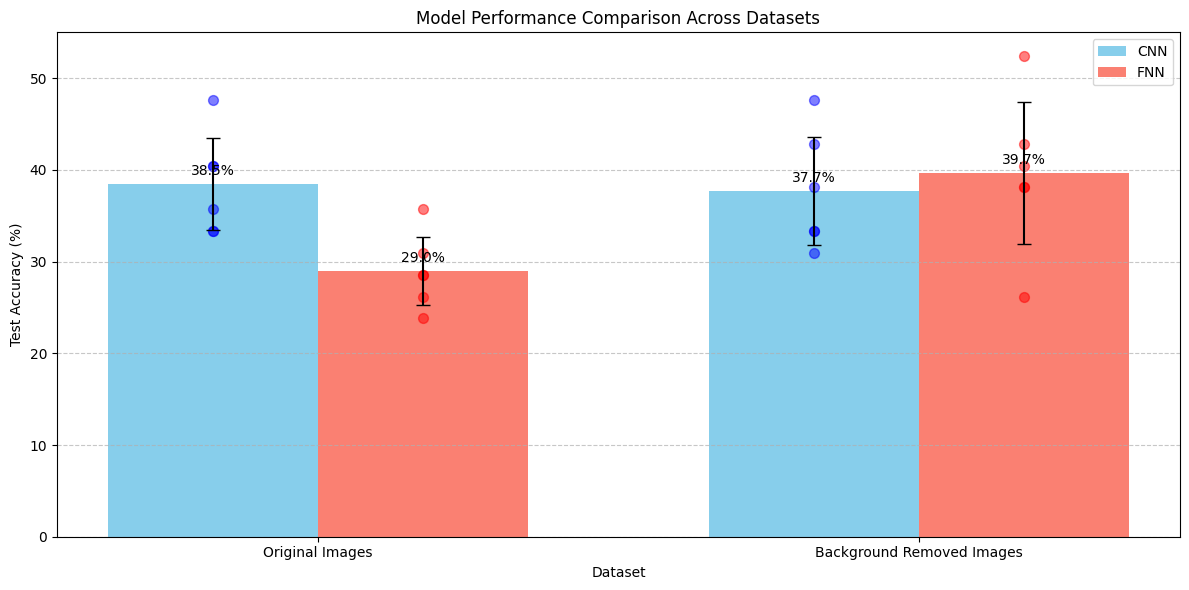

In [ ]:
plt.figure(figsize=(12, 6))

x = np.arange(len(test_results.keys()))
width = 0.35 

# Create the plot
for i, dataset_name in enumerate(test_results.keys()):
    cnn_accuracies = test_results[dataset_name]['CNN']['test_acc']
    fnn_accuracies = test_results[dataset_name]['FNN']['test_acc']
    
    # Calculate means and standard deviations
    cnn_mean = np.mean(cnn_accuracies)
    cnn_std = np.std(cnn_accuracies)
    fnn_mean = np.mean(fnn_accuracies)
    fnn_std = np.std(fnn_accuracies)
    
    # Plot bars with error bars
    plt.bar(x[i] - width/2, cnn_mean, width, yerr=cnn_std, 
            label='CNN' if i == 0 else '', color='skyblue', capsize=5)
    plt.bar(x[i] + width/2, fnn_mean, width, yerr=fnn_std, 
            label='FNN' if i == 0 else '', color='salmon', capsize=5)
    
    # Add individual data points
    plt.scatter([x[i] - width/2] * len(cnn_accuracies), cnn_accuracies, 
                color='blue', alpha=0.5, s=50)
    plt.scatter([x[i] + width/2] * len(fnn_accuracies), fnn_accuracies, 
                color='red', alpha=0.5, s=50)

# Customize the plot
plt.xlabel('Dataset')
plt.ylabel('Test Accuracy (%)')
plt.title('Model Performance Comparison Across Datasets')
plt.xticks(x, test_results.keys())
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Add mean values on top of bars
for i, dataset_name in enumerate(test_results.keys()):
    cnn_mean = np.mean(test_results[dataset_name]['CNN']['test_acc'])
    fnn_mean = np.mean(test_results[dataset_name]['FNN']['test_acc'])
    plt.text(x[i] - width/2, cnn_mean + 1, f'{cnn_mean:.1f}%', ha='center')
    plt.text(x[i] + width/2, fnn_mean + 1, f'{fnn_mean:.1f}%', ha='center')

plt.tight_layout()
plt.show()

### cnn_gen
 task 3 to create a cnn model with generalization techniques, we used data augmentation mainly with random rotation, color jitter and random affine to impute the training images. 

C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Using device: cpu

=== Processing Original Images ===

=== Training CNN on Original Images ===


Epoch 1/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.24it/s]


Epoch 1/20:
Train Loss: 1.2018, Train Acc: 35.60%
Val Loss: 1.5354, Val Acc: 42.50%


Epoch 2/20 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.36it/s]


Epoch 2/20:
Train Loss: 1.0163, Train Acc: 52.88%
Val Loss: 1.3645, Val Acc: 42.50%


Epoch 3/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.11it/s]


Epoch 3/20:
Train Loss: 0.8293, Train Acc: 64.40%
Val Loss: 1.3193, Val Acc: 42.50%


Epoch 4/20 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.35it/s]


Epoch 4/20:
Train Loss: 0.6945, Train Acc: 74.87%
Val Loss: 1.9817, Val Acc: 42.50%


Epoch 5/20 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.76it/s]


Epoch 5/20:
Train Loss: 0.5202, Train Acc: 86.91%
Val Loss: 1.9555, Val Acc: 42.50%


Epoch 6/20 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.87it/s]


Epoch 6/20:
Train Loss: 0.3690, Train Acc: 88.48%
Val Loss: 1.8301, Val Acc: 42.50%


Epoch 7/20 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.67it/s]


Epoch 7/20:
Train Loss: 0.2339, Train Acc: 96.34%
Val Loss: 1.6196, Val Acc: 47.50%


Epoch 8/20 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.72it/s]


Epoch 8/20:
Train Loss: 0.2085, Train Acc: 98.43%
Val Loss: 1.6656, Val Acc: 40.00%
Early stopping triggered after 8 epochs


Testing: 100%|██████████| 2/2 [00:01<00:00,  1.76it/s]


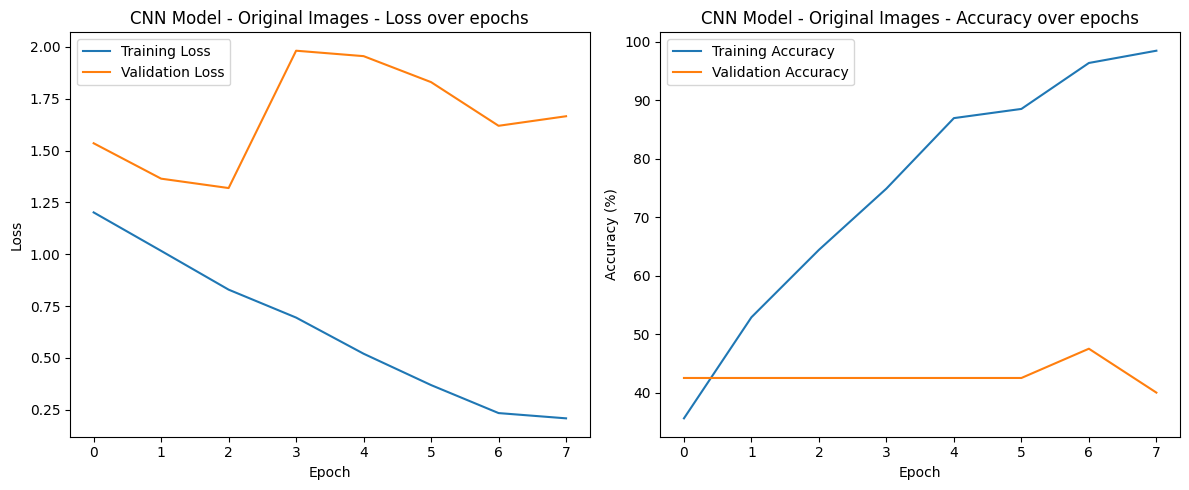

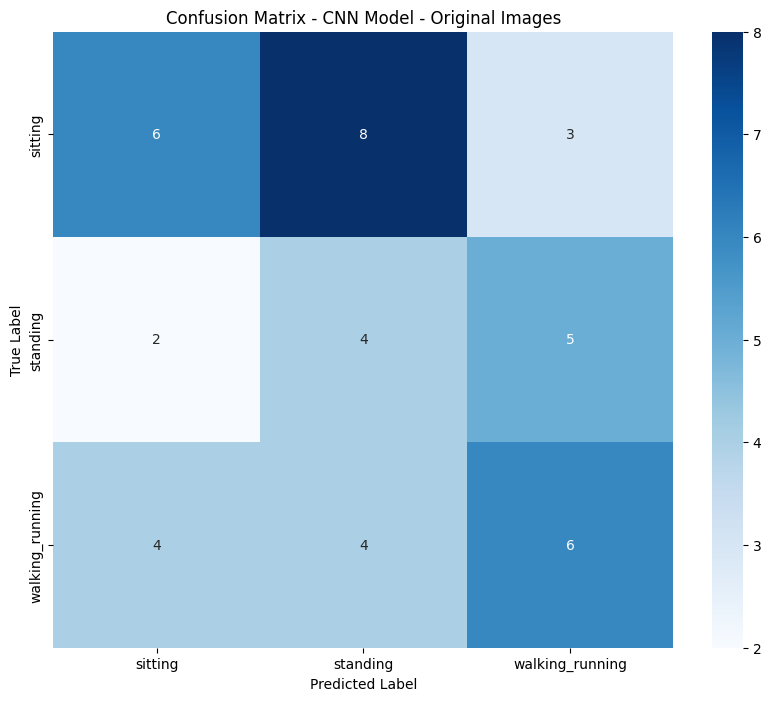

C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



=== Processing Background Removed Images ===

=== Training CNN on Background Removed Images ===


Epoch 1/20 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.68it/s]


Epoch 1/20:
Train Loss: 1.2187, Train Acc: 34.55%
Val Loss: 1.1457, Val Acc: 32.50%


Epoch 2/20 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.79it/s]


Epoch 2/20:
Train Loss: 0.9670, Train Acc: 59.16%
Val Loss: 1.1207, Val Acc: 32.50%


Epoch 3/20 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.70it/s]


Epoch 3/20:
Train Loss: 0.8339, Train Acc: 65.97%
Val Loss: 1.2398, Val Acc: 32.50%


Epoch 4/20 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.79it/s]


Epoch 4/20:
Train Loss: 0.7323, Train Acc: 73.30%
Val Loss: 1.2715, Val Acc: 32.50%


Epoch 5/20 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.67it/s]


Epoch 5/20:
Train Loss: 0.6021, Train Acc: 78.53%
Val Loss: 1.2644, Val Acc: 32.50%


Epoch 6/20 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.84it/s]


Epoch 6/20:
Train Loss: 0.4633, Train Acc: 86.91%
Val Loss: 1.2557, Val Acc: 37.50%


Epoch 7/20 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.72it/s]


Epoch 7/20:
Train Loss: 0.4007, Train Acc: 90.05%
Val Loss: 1.2507, Val Acc: 37.50%
Early stopping triggered after 7 epochs


Testing: 100%|██████████| 2/2 [00:01<00:00,  1.45it/s]


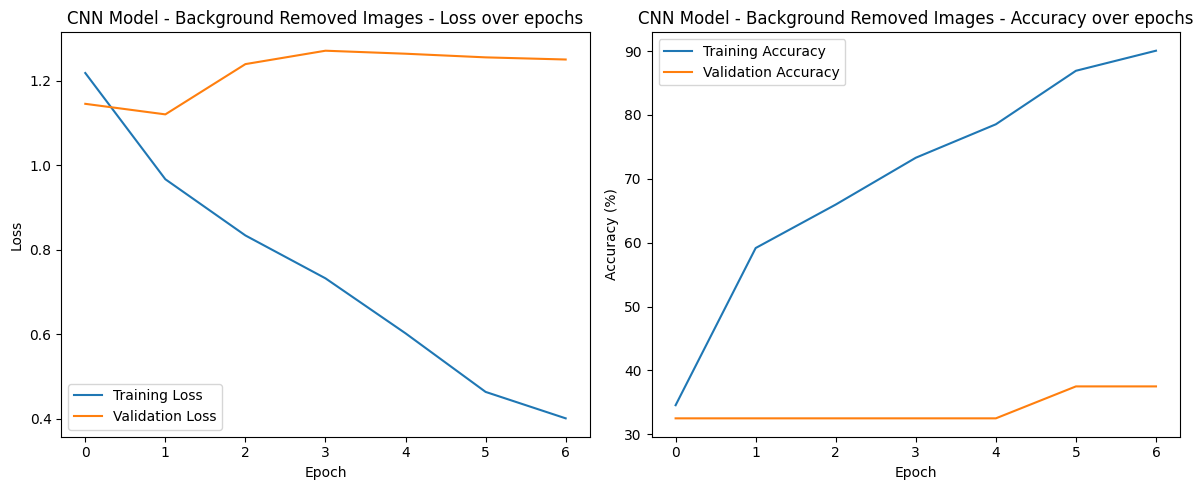

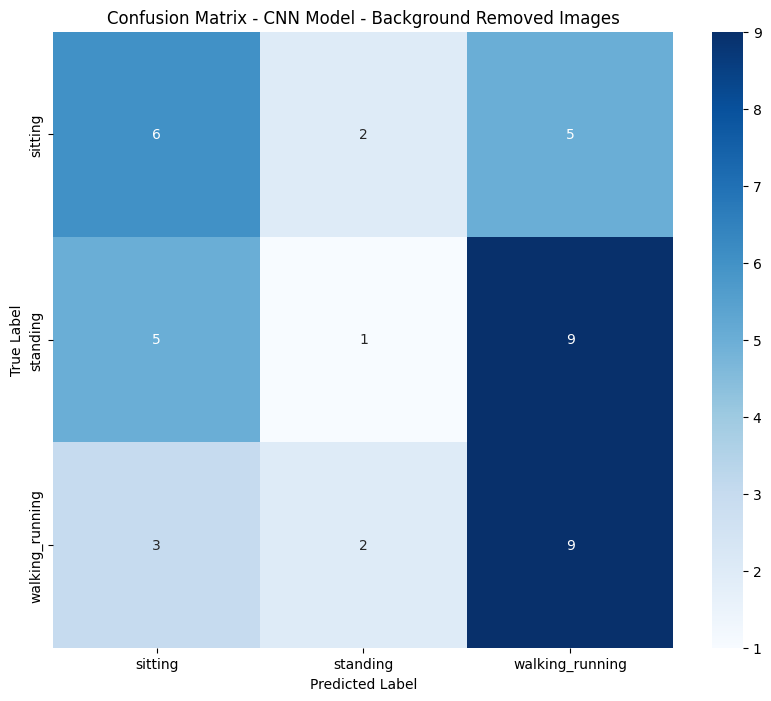


Original Images:
Test Loss: 1.5931, Test Accuracy: 38.10%

Classification Report:
                 precision    recall  f1-score   support

        sitting       0.50      0.35      0.41        17
       standing       0.25      0.36      0.30        11
walking_running       0.43      0.43      0.43        14

       accuracy                           0.38        42
      macro avg       0.39      0.38      0.38        42
   weighted avg       0.41      0.38      0.39        42


Background Removed Images:
Test Loss: 1.2836, Test Accuracy: 38.10%

Classification Report:
                 precision    recall  f1-score   support

        sitting       0.43      0.46      0.44        13
       standing       0.20      0.07      0.10        15
walking_running       0.39      0.64      0.49        14

       accuracy                           0.38        42
      macro avg       0.34      0.39      0.34        42
   weighted avg       0.33      0.38      0.34        42



In [ ]:
print(f'Using device: {device}')

# Create transforms for training (with augmentation) and validation/testing
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], 
                        std=[0.5, 0.5, 0.5])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],  
                        std=[0.5, 0.5, 0.5])
])

def cnn_model(num_classes=3):
    model = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=3, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),

        nn.Conv2d(32, 64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        
        nn.Conv2d(64, 128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        
        nn.Conv2d(128, 256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        
        # Flatten
        nn.Flatten(),
        
        # Fully Connected Layers
        nn.Linear(256 * 14 * 14, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Dropout(0.5),
        
        nn.Linear(512, 256),
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.Dropout(0.3),
        
        nn.Linear(256, num_classes)
    )
    return model

def train_model(model, train_loader, val_loader, test_loader, criterion, optimizer, num_epochs, device, patience=5):
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=2, verbose=True
    )
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Training'):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Validation'):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_loss = val_loss / len(val_loader)
        val_acc = 100 * correct / total
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        scheduler.step(val_loss)
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Early stopping triggered after {epoch+1} epochs')
                model.load_state_dict(best_model_state)
                break
    
    # Test the model
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc='Testing'):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    test_loss = test_loss / len(test_loader)
    test_acc = 100 * correct / total
    
    cm = confusion_matrix(all_labels, all_preds)
    class_report = classification_report(all_labels, all_preds, 
                                      target_names=['sitting', 'standing', 'walking_running'])
    
    return train_losses, val_losses, train_accs, val_accs, test_loss, test_acc, cm, class_report

def plot_metrics(train_losses, val_losses, train_accs, val_accs, model_name, dataset_name):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title(f'{model_name} - {dataset_name} - Loss over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.title(f'{model_name} - {dataset_name} - Accuracy over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(cm, model_name, dataset_name):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['sitting', 'standing', 'walking_running'],
                yticklabels=['sitting', 'standing', 'walking_running'])
    plt.title(f'Confusion Matrix - {model_name} - {dataset_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Initialize results storage
results = {}
datasets_to_compare = [
    ('organized_images', 'Original Images'),
    ('organized_images_br', 'Background Removed Images')
]

# Train and evaluate models for each dataset
for dataset_path, dataset_name in datasets_to_compare:
    print(f"\n=== Processing {dataset_name} ===")
    
    # First create the full dataset without any transforms
    full_dataset = datasets.ImageFolder(
        root=dataset_path,
        transform=None  
    )
    
    total_size = len(full_dataset)
    train_size = int(0.7 * total_size) 
    val_size = int(0.15 * total_size)  
    test_size = total_size - train_size - val_size 
    
    # Split the dataset
    train_dataset, val_dataset, test_dataset = random_split(
        full_dataset, [train_size, val_size, test_size]
    )
    
    # Now apply appropriate transforms to each split
    train_dataset.dataset.transform = train_transform  # Apply augmentation to training
    val_dataset.dataset.transform = val_test_transform  # No augmentation for validation
    test_dataset.dataset.transform = val_test_transform  # No augmentation for testing
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Initialize model
    model = cnn_model(num_classes=3).to(device)
    
    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Train and evaluate
    print(f"\n=== Training CNN on {dataset_name} ===")
    model_results = train_model(
        model, train_loader, val_loader, test_loader,
        criterion, optimizer, num_epochs, device, patience
    )
    
    # Plot metrics
    plot_metrics(
        model_results[0], model_results[1], model_results[2], model_results[3],
        'CNN Model', dataset_name
    )
    
    # Plot confusion matrix
    plot_confusion_matrix(model_results[6], 'CNN Model', dataset_name)
    
    # Store results
    results[dataset_name] = {
        'test_loss': model_results[4],
        'test_acc': model_results[5],
        'confusion_matrix': model_results[6],
        'classification_report': model_results[7]
    }


for dataset_name in results:
    print(f"\n{dataset_name}:")
    print("Test Loss: {:.4f}, Test Accuracy: {:.2f}%".format(
        results[dataset_name]['test_loss'],
        results[dataset_name]['test_acc']
    ))
    print("\nClassification Report:")
    print(results[dataset_name]['classification_report'])

#### transfer learning


Running experiment: Original


C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10:
Train Loss: 0.7461, Train Acc: 62.24%
Val Loss: 0.8600, Val Acc: 77.78%
Epoch 2/10:
Train Loss: 0.4734, Train Acc: 81.12%
Val Loss: 2.3748, Val Acc: 66.67%
Epoch 3/10:
Train Loss: 0.1852, Train Acc: 92.31%
Val Loss: 2.4265, Val Acc: 69.44%
Epoch 4/10:
Train Loss: 0.0899, Train Acc: 97.20%
Val Loss: 2.6676, Val Acc: 63.89%
Epoch 5/10:
Train Loss: 0.0678, Train Acc: 98.60%
Val Loss: 3.1543, Val Acc: 66.67%
Epoch 6/10:
Train Loss: 0.0352, Train Acc: 98.60%
Val Loss: 3.4242, Val Acc: 61.11%
Epoch 7/10:
Train Loss: 0.0581, Train Acc: 98.60%
Val Loss: 1.9834, Val Acc: 58.33%
Epoch 8/10:
Train Loss: 0.0790, Train Acc: 97.20%
Val Loss: 0.9445, Val Acc: 61.11%
Epoch 9/10:
Train Loss: 0.0985, Train Acc: 97.20%
Val Loss: 0.6626, Val Acc: 66.67%
Epoch 10/10:
Train Loss: 0.0500, Train Acc: 97.90%
Val Loss: 1.1645, Val Acc: 61.11%


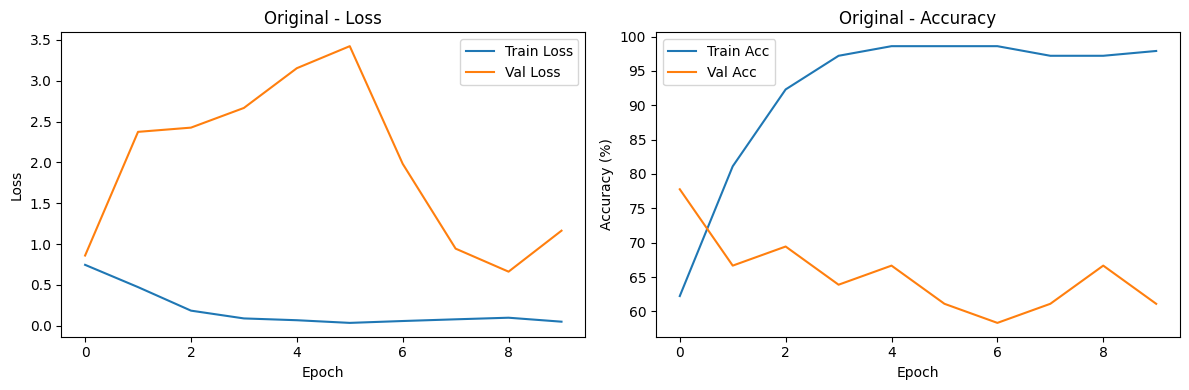

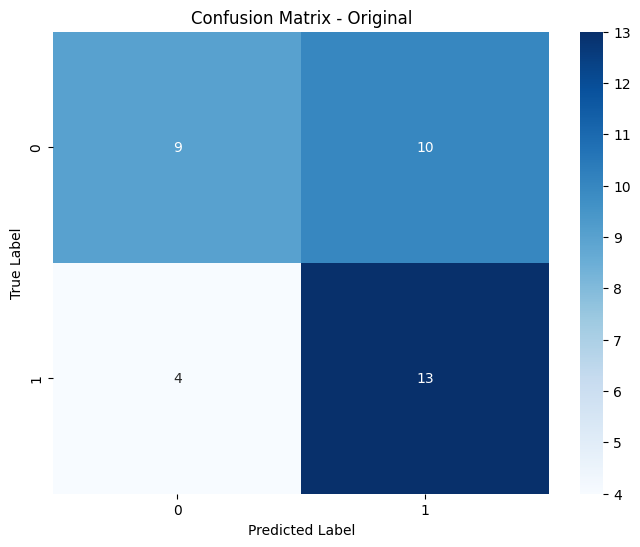


Training time: 123.12 seconds

Classification Report:
              precision    recall  f1-score   support

     sitting       0.69      0.47      0.56        19
    standing       0.57      0.76      0.65        17

    accuracy                           0.61        36
   macro avg       0.63      0.62      0.61        36
weighted avg       0.63      0.61      0.60        36


Running experiment: BackgroundRemoved


C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10:
Train Loss: 0.7542, Train Acc: 57.34%
Val Loss: 0.5466, Val Acc: 69.44%
Epoch 2/10:
Train Loss: 0.4493, Train Acc: 77.62%
Val Loss: 0.8662, Val Acc: 61.11%
Epoch 3/10:
Train Loss: 0.1649, Train Acc: 93.71%
Val Loss: 1.4612, Val Acc: 72.22%
Epoch 4/10:
Train Loss: 0.0983, Train Acc: 97.90%
Val Loss: 1.9707, Val Acc: 66.67%
Epoch 5/10:
Train Loss: 0.0800, Train Acc: 97.20%
Val Loss: 1.4351, Val Acc: 63.89%
Epoch 6/10:
Train Loss: 0.1104, Train Acc: 95.80%
Val Loss: 1.5409, Val Acc: 69.44%
Epoch 7/10:
Train Loss: 0.0852, Train Acc: 97.20%
Val Loss: 0.9509, Val Acc: 75.00%
Epoch 8/10:
Train Loss: 0.0130, Train Acc: 99.30%
Val Loss: 1.0860, Val Acc: 72.22%
Epoch 9/10:
Train Loss: 0.0410, Train Acc: 98.60%
Val Loss: 1.1794, Val Acc: 75.00%
Epoch 10/10:
Train Loss: 0.0379, Train Acc: 99.30%
Val Loss: 1.5232, Val Acc: 72.22%


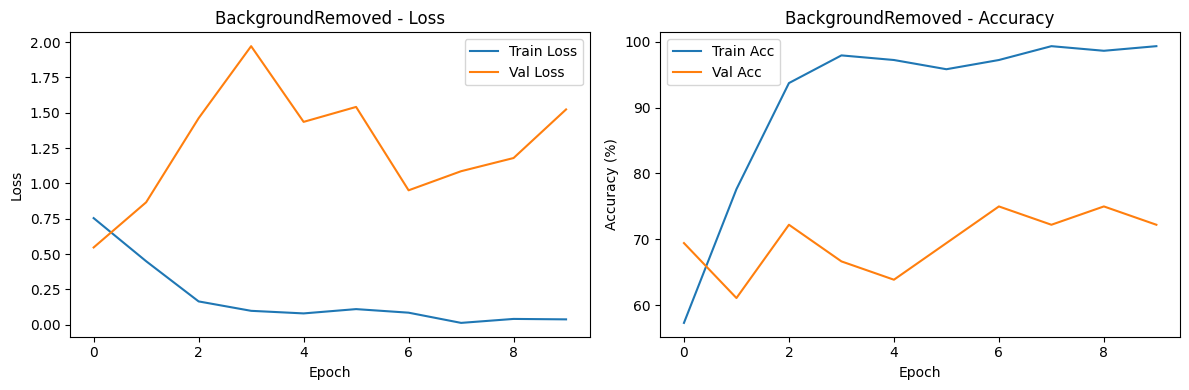

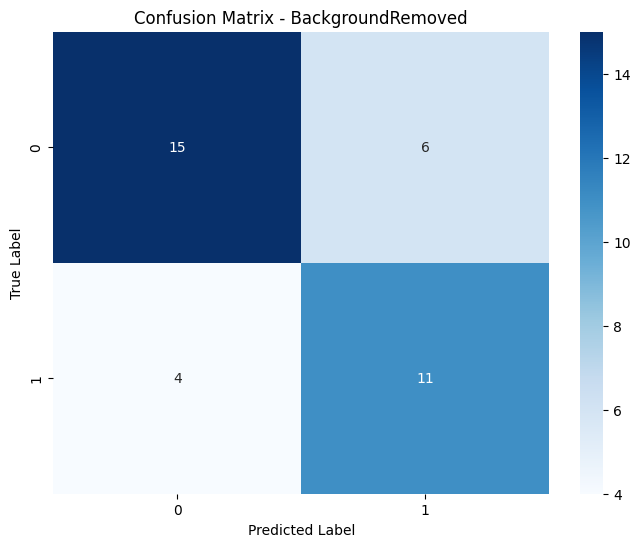


Training time: 154.98 seconds

Classification Report:
              precision    recall  f1-score   support

     sitting       0.79      0.71      0.75        21
    standing       0.65      0.73      0.69        15

    accuracy                           0.72        36
   macro avg       0.72      0.72      0.72        36
weighted avg       0.73      0.72      0.72        36



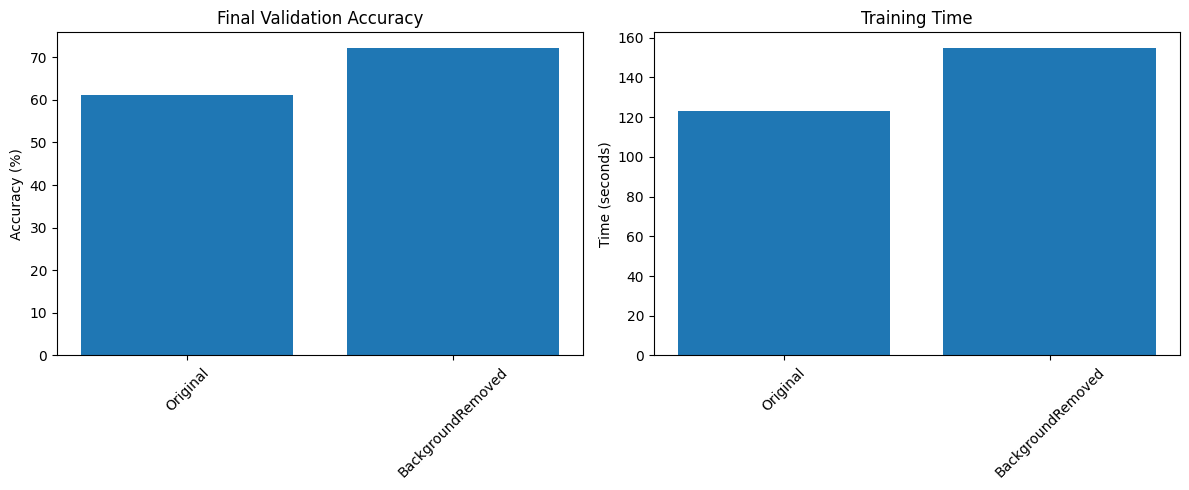

In [ ]:
class PoseDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = ['sitting', 'standing']
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        
        self.images = []
        self.labels = []
        
        for filename in os.listdir(root_dir):
            if filename.endswith(('.jpg', '.jpeg', '.png')):
                label = filename.split('_')[-1].split('.')[0]
                if label in self.classes:
                    self.images.append(filename)
                    self.labels.append(self.class_to_idx[label])
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.images[idx])
        image = Image.open(img_name).convert('RGB')  # Ensure RGB format
        
        if self.transform:
            image = self.transform(image)
        
        label = self.labels[idx]
        return image, label

# Model creation
def create_model(num_classes=2):
    model = models.mobilenet_v2(pretrained=True)
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    return model

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct / total
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        
        val_loss = val_loss / len(val_loader)
        val_acc = 100. * correct / total
        
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
    
    return history

# Evaluation function
def evaluate_model(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    cm = confusion_matrix(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, target_names=['sitting', 'standing'])
    
    return cm, report

# Visualization functions
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def plot_training_history(history, title):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'], label='Val Acc')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

experiments = [
    {'name': 'Original', 'path': 'images'},
    {'name': 'BackgroundRemoved', 'path': 'removed_background'}
]

results = {}

# Transform for all images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],  
                        std=[0.5, 0.5, 0.5])
])

for exp in experiments:
    print(f"\nRunning experiment: {exp['name']}")
    

    dataset = PoseDataset(exp['path'], transform=transform)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    

    model = create_model(num_classes=2)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    

    start_time = time.time()
    history = train_model(model, train_loader, val_loader, criterion, optimizer)
    training_time = time.time() - start_time
    

    cm, report = evaluate_model(model, val_loader)
    

    results[exp['name']] = {
        'history': history,
        'confusion_matrix': cm,
        'classification_report': report,
        'training_time': training_time
    }

    plot_training_history(history, exp['name'])
    plot_confusion_matrix(cm, f'Confusion Matrix - {exp["name"]}')
    
    print(f"\nTraining time: {training_time:.2f} seconds")
    print("\nClassification Report:")
    print(report)

# Compare results
final_accuracies = {name: results[name]['history']['val_acc'][-1] for name in results}
training_times = {name: results[name]['training_time'] for name in results}

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.bar(final_accuracies.keys(), final_accuracies.values())
plt.title('Final Validation Accuracy')
plt.xticks(rotation=45)
plt.ylabel('Accuracy (%)')

plt.subplot(1, 2, 2)
plt.bar(training_times.keys(), training_times.values())
plt.title('Training Time')
plt.xticks(rotation=45)
plt.ylabel('Time (seconds)')

plt.tight_layout()
plt.show() 


Running experiment: Original

Running experiment with strategy: no_freezing


C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10:
Train Loss: 0.8771, Train Acc: 56.64%
Val Loss: 0.5162, Val Acc: 66.67%
Epoch 2/10:
Train Loss: 0.3467, Train Acc: 83.22%
Val Loss: 0.4665, Val Acc: 69.44%
Epoch 3/10:
Train Loss: 0.0723, Train Acc: 96.50%
Val Loss: 1.0308, Val Acc: 61.11%
Epoch 4/10:
Train Loss: 0.1965, Train Acc: 95.10%
Val Loss: 1.1783, Val Acc: 63.89%
Epoch 5/10:
Train Loss: 0.1155, Train Acc: 97.20%
Val Loss: 2.0011, Val Acc: 58.33%
Epoch 6/10:
Train Loss: 0.1329, Train Acc: 95.80%
Val Loss: 1.5215, Val Acc: 41.67%
Epoch 7/10:
Train Loss: 0.1772, Train Acc: 93.71%
Val Loss: 1.8862, Val Acc: 58.33%
Epoch 8/10:
Train Loss: 0.1204, Train Acc: 97.20%
Val Loss: 2.4402, Val Acc: 50.00%
Epoch 9/10:
Train Loss: 0.2126, Train Acc: 95.10%
Val Loss: 1.3637, Val Acc: 50.00%
Epoch 10/10:
Train Loss: 0.0736, Train Acc: 97.90%
Val Loss: 1.0219, Val Acc: 66.67%


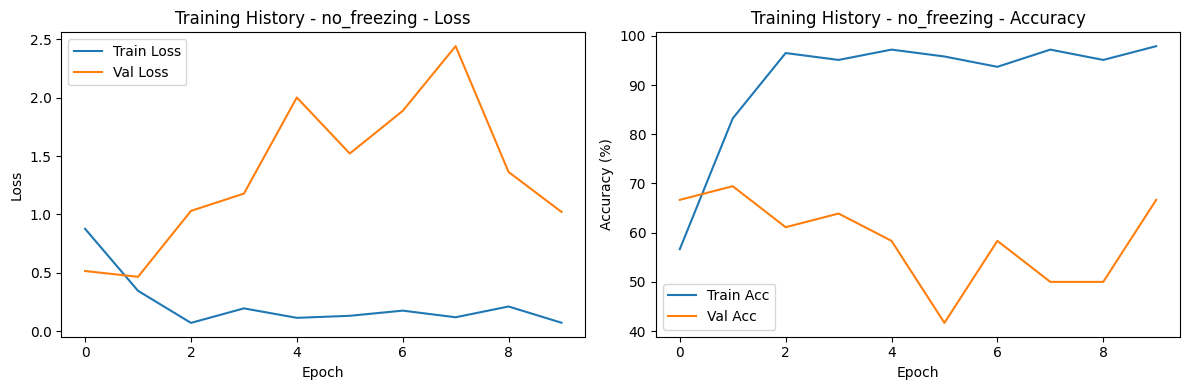

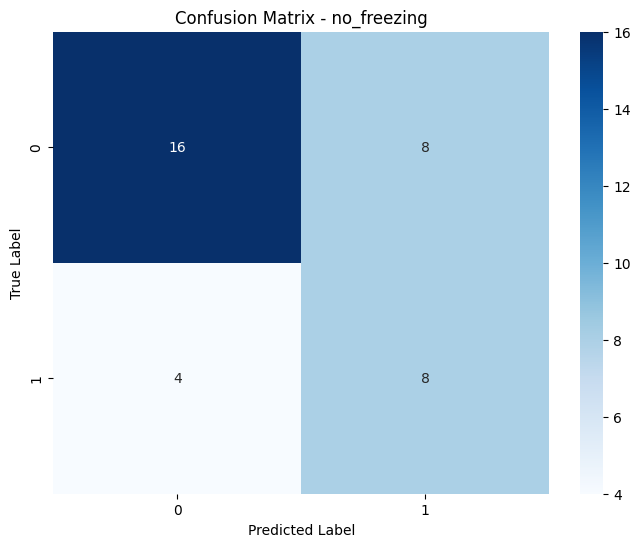


Training time: 167.72 seconds

Classification Report:
              precision    recall  f1-score   support

     sitting       0.80      0.67      0.73        24
    standing       0.50      0.67      0.57        12

    accuracy                           0.67        36
   macro avg       0.65      0.67      0.65        36
weighted avg       0.70      0.67      0.68        36


Running experiment with strategy: partial_freezing


C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10:
Train Loss: 0.7861, Train Acc: 53.85%
Val Loss: 0.4761, Val Acc: 72.22%
Epoch 2/10:
Train Loss: 0.2975, Train Acc: 88.11%
Val Loss: 0.3247, Val Acc: 77.78%
Epoch 3/10:
Train Loss: 0.1436, Train Acc: 95.10%
Val Loss: 0.4166, Val Acc: 75.00%
Epoch 4/10:
Train Loss: 0.0653, Train Acc: 98.60%
Val Loss: 0.7448, Val Acc: 77.78%
Epoch 5/10:
Train Loss: 0.0558, Train Acc: 99.30%
Val Loss: 1.0146, Val Acc: 69.44%
Epoch 6/10:
Train Loss: 0.0202, Train Acc: 97.90%
Val Loss: 0.9236, Val Acc: 80.56%
Epoch 7/10:
Train Loss: 0.0278, Train Acc: 98.60%
Val Loss: 0.8355, Val Acc: 75.00%
Epoch 8/10:
Train Loss: 0.0158, Train Acc: 100.00%
Val Loss: 1.3435, Val Acc: 77.78%
Epoch 9/10:
Train Loss: 0.0085, Train Acc: 100.00%
Val Loss: 1.5985, Val Acc: 72.22%
Epoch 10/10:
Train Loss: 0.0017, Train Acc: 100.00%
Val Loss: 1.8182, Val Acc: 72.22%


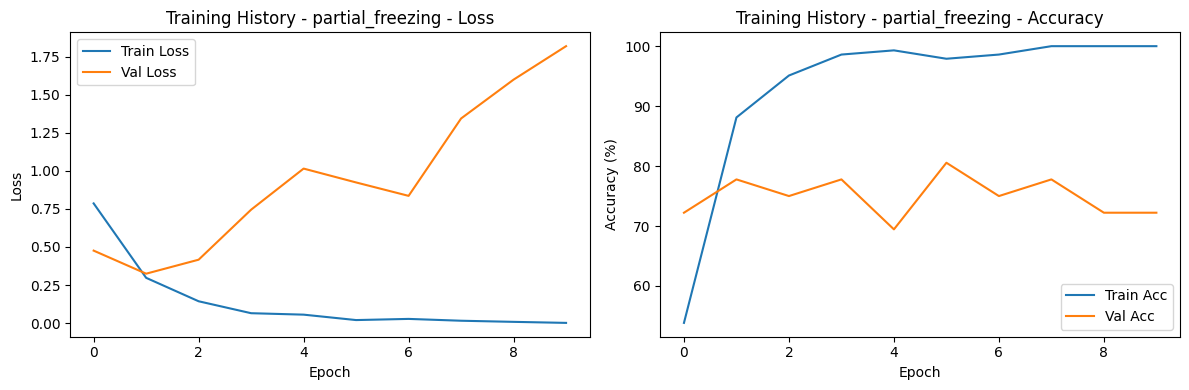

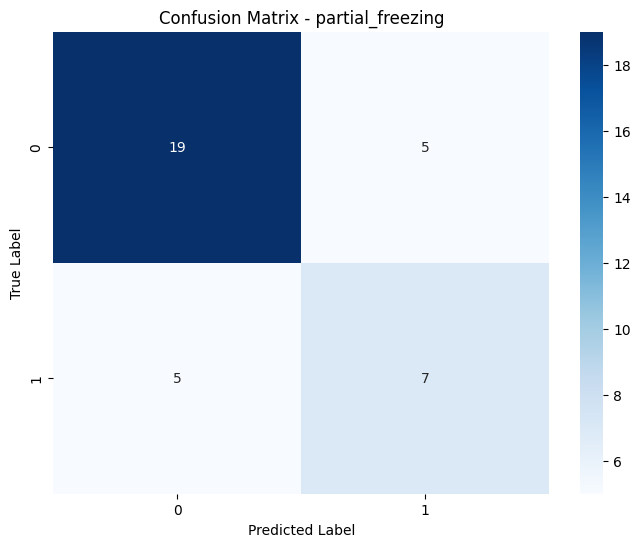


Training time: 81.01 seconds

Classification Report:
              precision    recall  f1-score   support

     sitting       0.79      0.79      0.79        24
    standing       0.58      0.58      0.58        12

    accuracy                           0.72        36
   macro avg       0.69      0.69      0.69        36
weighted avg       0.72      0.72      0.72        36


Running experiment with strategy: feature_extraction


C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10:
Train Loss: 0.7570, Train Acc: 51.75%
Val Loss: 0.8250, Val Acc: 44.44%
Epoch 2/10:
Train Loss: 0.6490, Train Acc: 60.14%
Val Loss: 0.5609, Val Acc: 69.44%
Epoch 3/10:
Train Loss: 0.6262, Train Acc: 65.73%
Val Loss: 0.6156, Val Acc: 63.89%
Epoch 4/10:
Train Loss: 0.5577, Train Acc: 74.13%
Val Loss: 0.5142, Val Acc: 77.78%
Epoch 5/10:
Train Loss: 0.5625, Train Acc: 67.83%
Val Loss: 0.4993, Val Acc: 80.56%
Epoch 6/10:
Train Loss: 0.4743, Train Acc: 83.22%
Val Loss: 0.5198, Val Acc: 69.44%
Epoch 7/10:
Train Loss: 0.4485, Train Acc: 87.41%
Val Loss: 0.4388, Val Acc: 83.33%
Epoch 8/10:
Train Loss: 0.4584, Train Acc: 83.92%
Val Loss: 0.4187, Val Acc: 77.78%
Epoch 9/10:
Train Loss: 0.4143, Train Acc: 83.92%
Val Loss: 0.4614, Val Acc: 69.44%
Epoch 10/10:
Train Loss: 0.4037, Train Acc: 88.11%
Val Loss: 0.3968, Val Acc: 77.78%


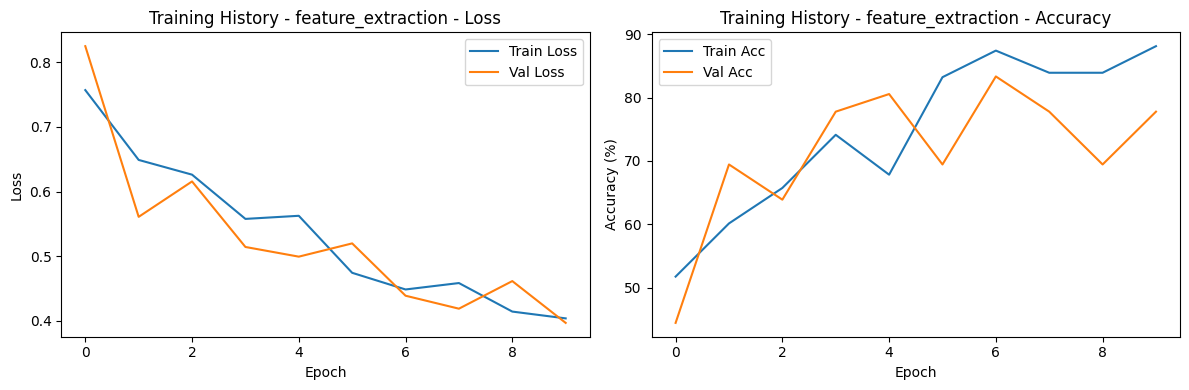

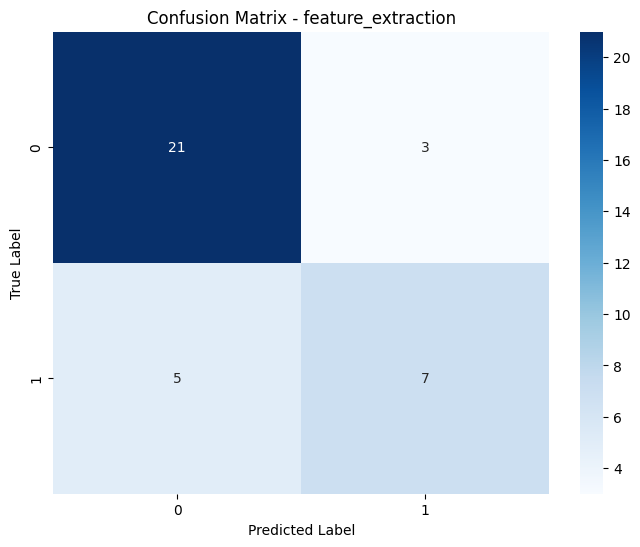


Training time: 88.95 seconds

Classification Report:
              precision    recall  f1-score   support

     sitting       0.81      0.88      0.84        24
    standing       0.70      0.58      0.64        12

    accuracy                           0.78        36
   macro avg       0.75      0.73      0.74        36
weighted avg       0.77      0.78      0.77        36



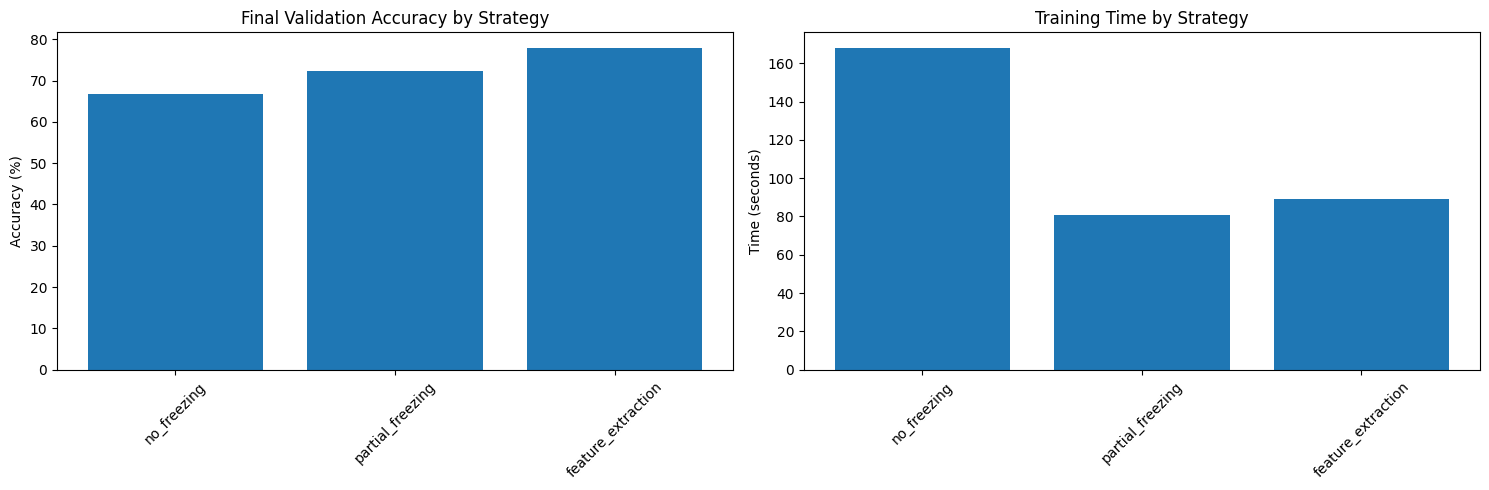


Strategy Comparison Summary:

no_freezing:
Final Validation Accuracy: 66.67%
Training Time: 167.72 seconds
Final Training Loss: 0.0736
Final Validation Loss: 1.0219

partial_freezing:
Final Validation Accuracy: 72.22%
Training Time: 81.01 seconds
Final Training Loss: 0.0017
Final Validation Loss: 1.8182

feature_extraction:
Final Validation Accuracy: 77.78%
Training Time: 88.95 seconds
Final Training Loss: 0.4037
Final Validation Loss: 0.3968

Running experiment: BackgroundRemoved

Running experiment with strategy: no_freezing


C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10:
Train Loss: 0.7805, Train Acc: 60.14%
Val Loss: 0.9363, Val Acc: 63.89%
Epoch 2/10:
Train Loss: 0.4051, Train Acc: 81.12%
Val Loss: 2.2349, Val Acc: 50.00%
Epoch 3/10:
Train Loss: 0.2146, Train Acc: 90.21%
Val Loss: 1.2470, Val Acc: 69.44%
Epoch 4/10:
Train Loss: 0.0826, Train Acc: 98.60%
Val Loss: 2.1930, Val Acc: 63.89%
Epoch 5/10:
Train Loss: 0.0506, Train Acc: 99.30%
Val Loss: 1.9421, Val Acc: 61.11%
Epoch 6/10:
Train Loss: 0.0268, Train Acc: 99.30%
Val Loss: 2.1198, Val Acc: 58.33%
Epoch 7/10:
Train Loss: 0.0831, Train Acc: 96.50%
Val Loss: 0.7715, Val Acc: 72.22%
Epoch 8/10:
Train Loss: 0.0561, Train Acc: 98.60%
Val Loss: 1.8973, Val Acc: 63.89%
Epoch 9/10:
Train Loss: 0.1046, Train Acc: 96.50%
Val Loss: 4.7098, Val Acc: 52.78%
Epoch 10/10:
Train Loss: 0.1992, Train Acc: 91.61%
Val Loss: 3.4361, Val Acc: 55.56%


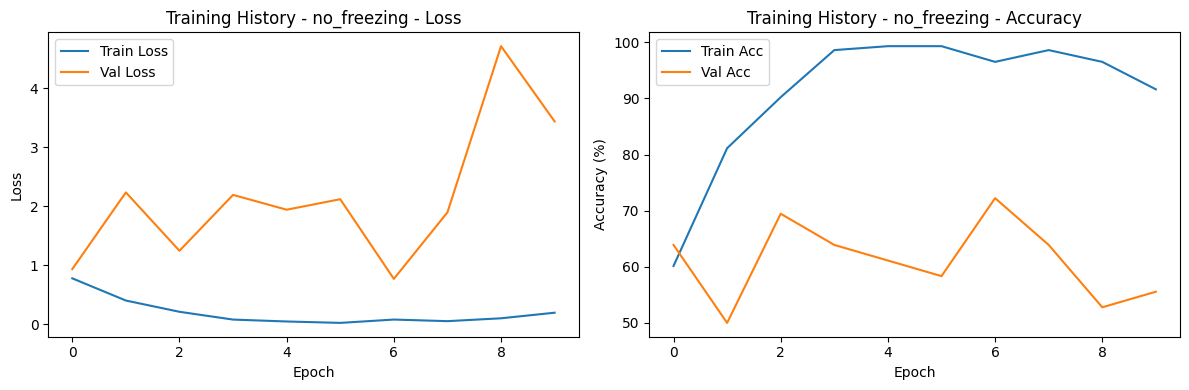

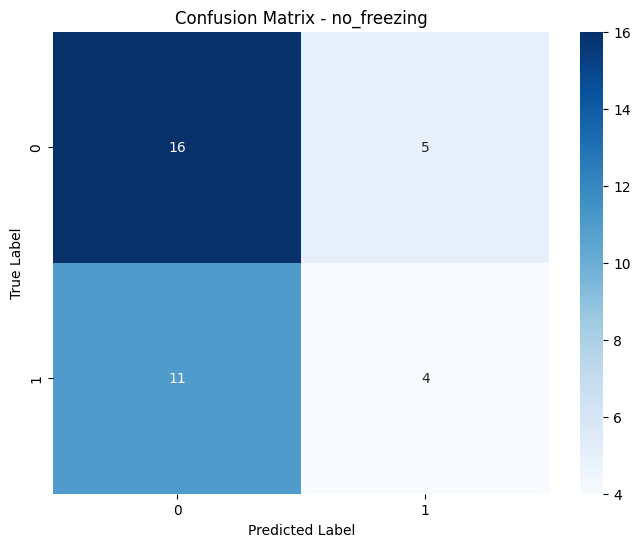


Training time: 116.20 seconds

Classification Report:
              precision    recall  f1-score   support

     sitting       0.59      0.76      0.67        21
    standing       0.44      0.27      0.33        15

    accuracy                           0.56        36
   macro avg       0.52      0.51      0.50        36
weighted avg       0.53      0.56      0.53        36


Running experiment with strategy: partial_freezing


C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10:
Train Loss: 0.6627, Train Acc: 62.24%
Val Loss: 2.5419, Val Acc: 47.22%
Epoch 2/10:
Train Loss: 0.3515, Train Acc: 83.92%
Val Loss: 0.7927, Val Acc: 61.11%
Epoch 3/10:
Train Loss: 0.1230, Train Acc: 96.50%
Val Loss: 0.9440, Val Acc: 63.89%
Epoch 4/10:
Train Loss: 0.1140, Train Acc: 96.50%
Val Loss: 0.8908, Val Acc: 69.44%
Epoch 5/10:
Train Loss: 0.0883, Train Acc: 96.50%
Val Loss: 0.9751, Val Acc: 72.22%
Epoch 6/10:
Train Loss: 0.1369, Train Acc: 92.31%
Val Loss: 1.1975, Val Acc: 61.11%
Epoch 7/10:
Train Loss: 0.0174, Train Acc: 100.00%
Val Loss: 1.5693, Val Acc: 58.33%
Epoch 8/10:
Train Loss: 0.0305, Train Acc: 99.30%
Val Loss: 1.6274, Val Acc: 61.11%
Epoch 9/10:
Train Loss: 0.0098, Train Acc: 100.00%
Val Loss: 1.5730, Val Acc: 61.11%
Epoch 10/10:
Train Loss: 0.0124, Train Acc: 99.30%
Val Loss: 1.5681, Val Acc: 66.67%


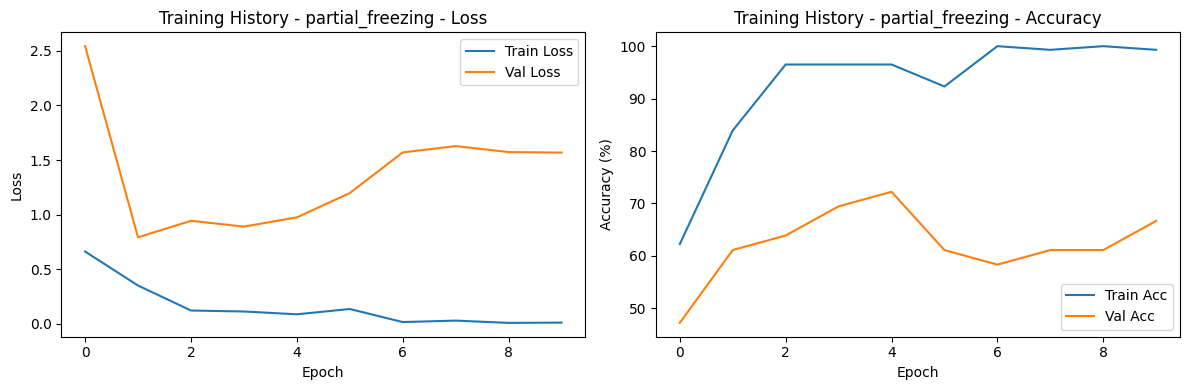

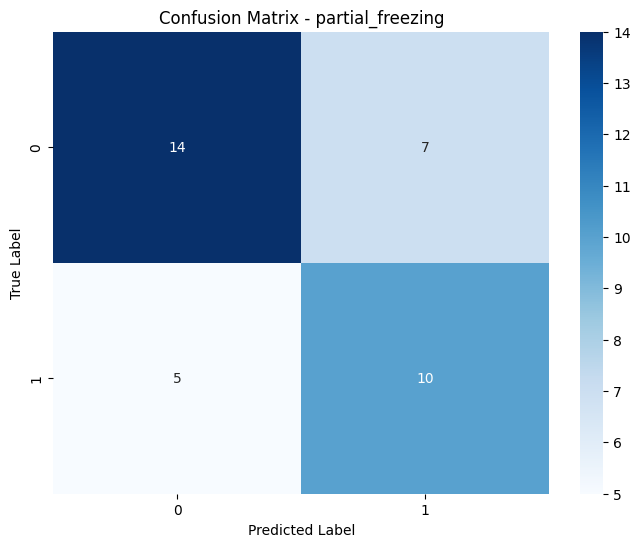


Training time: 56.93 seconds

Classification Report:
              precision    recall  f1-score   support

     sitting       0.74      0.67      0.70        21
    standing       0.59      0.67      0.62        15

    accuracy                           0.67        36
   macro avg       0.66      0.67      0.66        36
weighted avg       0.67      0.67      0.67        36


Running experiment with strategy: feature_extraction


C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10:
Train Loss: 0.7788, Train Acc: 45.45%
Val Loss: 0.9211, Val Acc: 44.44%
Epoch 2/10:
Train Loss: 0.6899, Train Acc: 58.74%
Val Loss: 0.7491, Val Acc: 50.00%
Epoch 3/10:
Train Loss: 0.6061, Train Acc: 67.83%
Val Loss: 0.7769, Val Acc: 50.00%
Epoch 4/10:
Train Loss: 0.5897, Train Acc: 71.33%
Val Loss: 0.7893, Val Acc: 47.22%
Epoch 5/10:
Train Loss: 0.5251, Train Acc: 78.32%
Val Loss: 0.6187, Val Acc: 55.56%
Epoch 6/10:
Train Loss: 0.4851, Train Acc: 81.82%
Val Loss: 0.6876, Val Acc: 50.00%
Epoch 7/10:
Train Loss: 0.4600, Train Acc: 82.52%
Val Loss: 0.7016, Val Acc: 52.78%
Epoch 8/10:
Train Loss: 0.4128, Train Acc: 83.92%
Val Loss: 0.6052, Val Acc: 52.78%
Epoch 9/10:
Train Loss: 0.3859, Train Acc: 86.01%
Val Loss: 0.6825, Val Acc: 50.00%
Epoch 10/10:
Train Loss: 0.4162, Train Acc: 86.01%
Val Loss: 0.6290, Val Acc: 52.78%


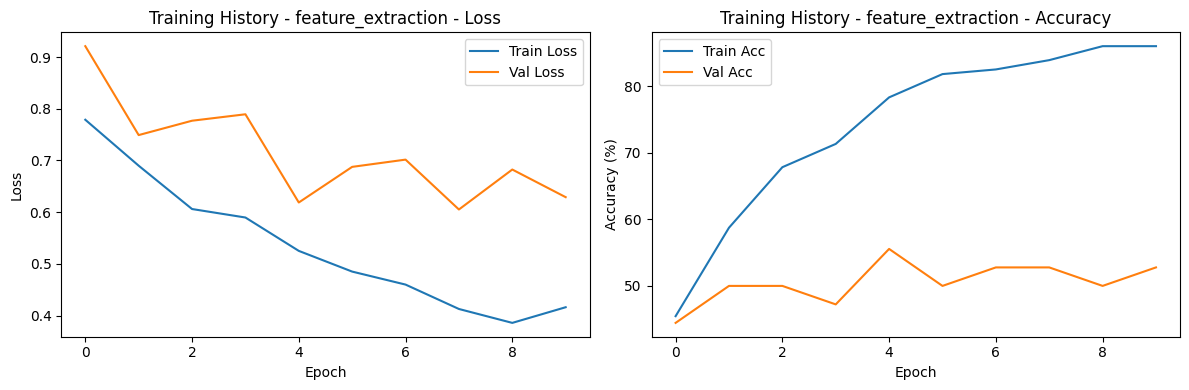

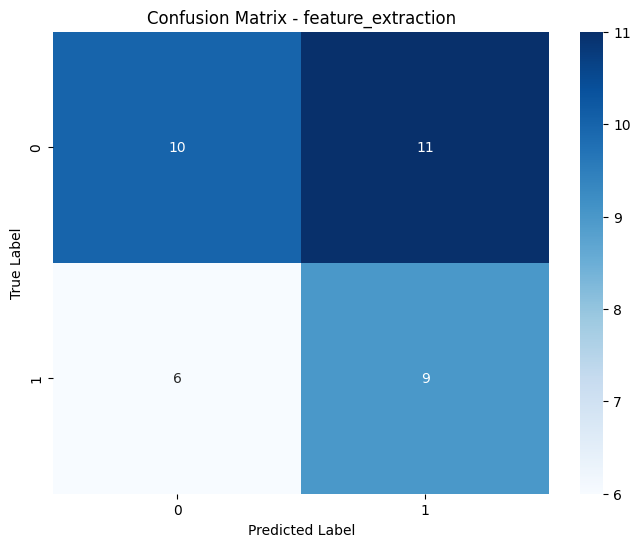


Training time: 48.92 seconds

Classification Report:
              precision    recall  f1-score   support

     sitting       0.62      0.48      0.54        21
    standing       0.45      0.60      0.51        15

    accuracy                           0.53        36
   macro avg       0.54      0.54      0.53        36
weighted avg       0.55      0.53      0.53        36



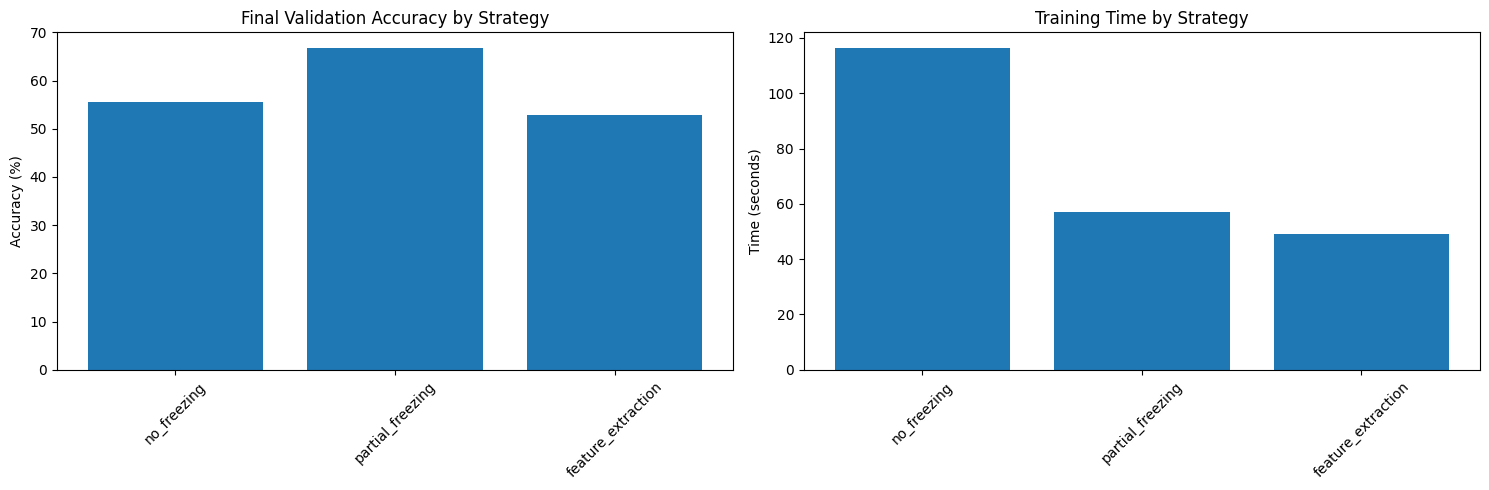


Strategy Comparison Summary:

no_freezing:
Final Validation Accuracy: 55.56%
Training Time: 116.20 seconds
Final Training Loss: 0.1992
Final Validation Loss: 3.4361

partial_freezing:
Final Validation Accuracy: 66.67%
Training Time: 56.93 seconds
Final Training Loss: 0.0124
Final Validation Loss: 1.5681

feature_extraction:
Final Validation Accuracy: 52.78%
Training Time: 48.92 seconds
Final Training Loss: 0.4162
Final Validation Loss: 0.6290


In [ ]:

def create_model(strategy='no_freezing', num_classes=2):
    model = models.mobilenet_v2(pretrained=True)
    
    if strategy == 'no_freezing':
        # All layers trainable
        pass
    
    elif strategy == 'partial_freezing':
        # Freeze all layers initially
        for param in model.parameters():
            param.requires_grad = False
        # Unfreeze last 4 layers
        for param in model.features[-4:].parameters():
            param.requires_grad = True
    
    elif strategy == 'feature_extraction':
        # Freeze all layers except classifier
        for param in model.parameters():
            param.requires_grad = False
        for param in model.classifier.parameters():
            param.requires_grad = True
    
    
    # Modify classifier for binary classification
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    return model

# Modified training function to support different strategies
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, strategy='no_freezing'):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    
    for epoch in range(num_epochs):
        
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct / total
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        
        val_loss = val_loss / len(val_loader)
        val_acc = 100. * correct / total
        
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
    
    return history

# Main experiment to compare strategies
strategies = [
    'no_freezing',
    'partial_freezing',
    'feature_extraction'
]

results = {}
for exp in experiments:
    print(f"\nRunning experiment: {exp['name']}")
    
    # Create dataset
    dataset = PoseDataset(exp['path'], transform=transform)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    for strategy in strategies:
        print(f"\nRunning experiment with strategy: {strategy}")
        
        # Create model
        model = create_model(strategy=strategy)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        criterion = nn.CrossEntropyLoss()
        
        # Training
        start_time = time.time()
        history = train_model(model, train_loader, val_loader, criterion, optimizer, strategy=strategy)
        training_time = time.time() - start_time
        
        # Evaluation
        cm, report = evaluate_model(model, val_loader)
        
        # Store results
        results[strategy] = {
            'history': history,
            'confusion_matrix': cm,
            'classification_report': report,
            'training_time': training_time
        }
        
        # Visualize results
        plot_training_history(history, f'Training History - {strategy}')
        plot_confusion_matrix(cm, f'Confusion Matrix - {strategy}')
        
        print(f"\nTraining time: {training_time:.2f} seconds")
        print("\nClassification Report:")
        print(report)

    # Compare results
    plt.figure(figsize=(15, 5))

    # Plot final accuracies
    plt.subplot(1, 2, 1)
    final_accuracies = {strategy: results[strategy]['history']['val_acc'][-1] for strategy in strategies}
    plt.bar(final_accuracies.keys(), final_accuracies.values())
    plt.title('Final Validation Accuracy by Strategy')
    plt.xticks(rotation=45)
    plt.ylabel('Accuracy (%)')

    # Plot training times
    plt.subplot(1, 2, 2)
    training_times = {strategy: results[strategy]['training_time'] for strategy in strategies}
    plt.bar(training_times.keys(), training_times.values())
    plt.title('Training Time by Strategy')
    plt.xticks(rotation=45)
    plt.ylabel('Time (seconds)')

    plt.tight_layout()
    plt.show()

    # Print summary
    print("\nStrategy Comparison Summary:")
    for strategy in strategies:
        print(f"\n{strategy}:")
        print(f"Final Validation Accuracy: {results[strategy]['history']['val_acc'][-1]:.2f}%")
        print(f"Training Time: {results[strategy]['training_time']:.2f} seconds")
        print(f"Final Training Loss: {results[strategy]['history']['train_loss'][-1]:.4f}")
        print(f"Final Validation Loss: {results[strategy]['history']['val_loss'][-1]:.4f}")

create final model with selected strategy of feature extraction

Dataset path :  organized_images


C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10:
Train Loss: 1.1124, Train Acc: 39.27%
Val Loss: 1.0497, Val Acc: 37.50%
Test Loss: 1.1509, Test Acc: 28.57%
Epoch 2/10:
Train Loss: 0.9604, Train Acc: 54.45%
Val Loss: 0.9151, Val Acc: 65.00%
Test Loss: 1.0391, Test Acc: 42.86%
Epoch 3/10:
Train Loss: 0.8334, Train Acc: 67.02%
Val Loss: 0.9911, Val Acc: 52.50%
Test Loss: 1.0376, Test Acc: 42.86%
Epoch 4/10:
Train Loss: 0.7721, Train Acc: 72.25%
Val Loss: 0.9949, Val Acc: 57.50%
Test Loss: 1.0042, Test Acc: 50.00%
Early stopping triggered after 5 epochs


C:\Users\USER\AppData\Local\Temp\ipykernel_13548\1969999626.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


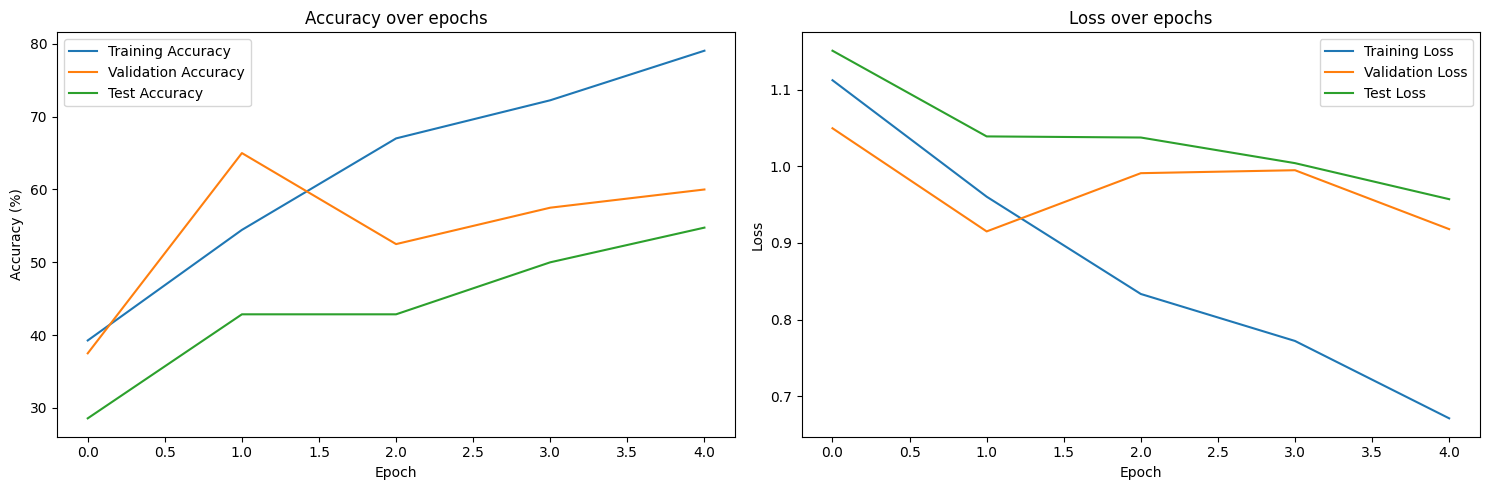


Final Metrics:
Best Training Accuracy: 79.06%
Best Validation Accuracy: 65.00%
Final Test Accuracy: 54.76%

Classification Report:
                 precision    recall  f1-score   support

        sitting       0.75      0.46      0.57        13
       standing       0.40      0.22      0.29        18
walking_running       0.33      0.73      0.46        11

       accuracy                           0.43        42
      macro avg       0.49      0.47      0.44        42
   weighted avg       0.49      0.43      0.42        42



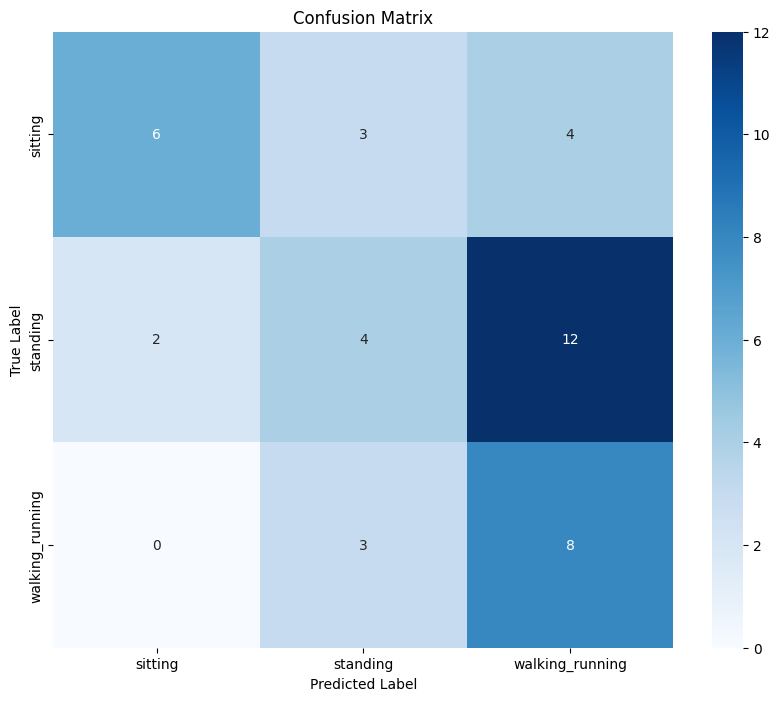

Dataset path :  organized_images_br


C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10:
Train Loss: 1.0876, Train Acc: 42.93%
Val Loss: 0.9931, Val Acc: 50.00%
Test Loss: 0.9816, Test Acc: 47.62%
Epoch 2/10:
Train Loss: 1.0276, Train Acc: 48.69%
Val Loss: 0.9408, Val Acc: 60.00%
Test Loss: 0.9368, Test Acc: 52.38%
Epoch 3/10:
Train Loss: 0.8862, Train Acc: 64.92%
Val Loss: 0.8817, Val Acc: 60.00%
Test Loss: 0.8155, Test Acc: 64.29%
Epoch 4/10:
Train Loss: 0.8338, Train Acc: 67.54%
Val Loss: 0.8547, Val Acc: 75.00%
Test Loss: 0.7902, Test Acc: 61.90%
Epoch 5/10:
Train Loss: 0.7469, Train Acc: 74.35%
Val Loss: 0.8349, Val Acc: 55.00%
Test Loss: 0.7202, Test Acc: 66.67%
Epoch 6/10:
Train Loss: 0.6809, Train Acc: 76.44%
Val Loss: 0.8071, Val Acc: 67.50%
Test Loss: 0.6846, Test Acc: 64.29%
Epoch 7/10:
Train Loss: 0.6391, Train Acc: 82.72%
Val Loss: 0.7920, Val Acc: 72.50%
Test Loss: 0.6774, Test Acc: 61.90%
Epoch 8/10:
Train Loss: 0.6521, Train Acc: 78.01%
Val Loss: 0.7891, Val Acc: 60.00%
Test Loss: 0.6238, Test Acc: 71.43%
Epoch 9/10:
Train Loss: 0.6209, Train Ac

C:\Users\USER\AppData\Local\Temp\ipykernel_13548\1969999626.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


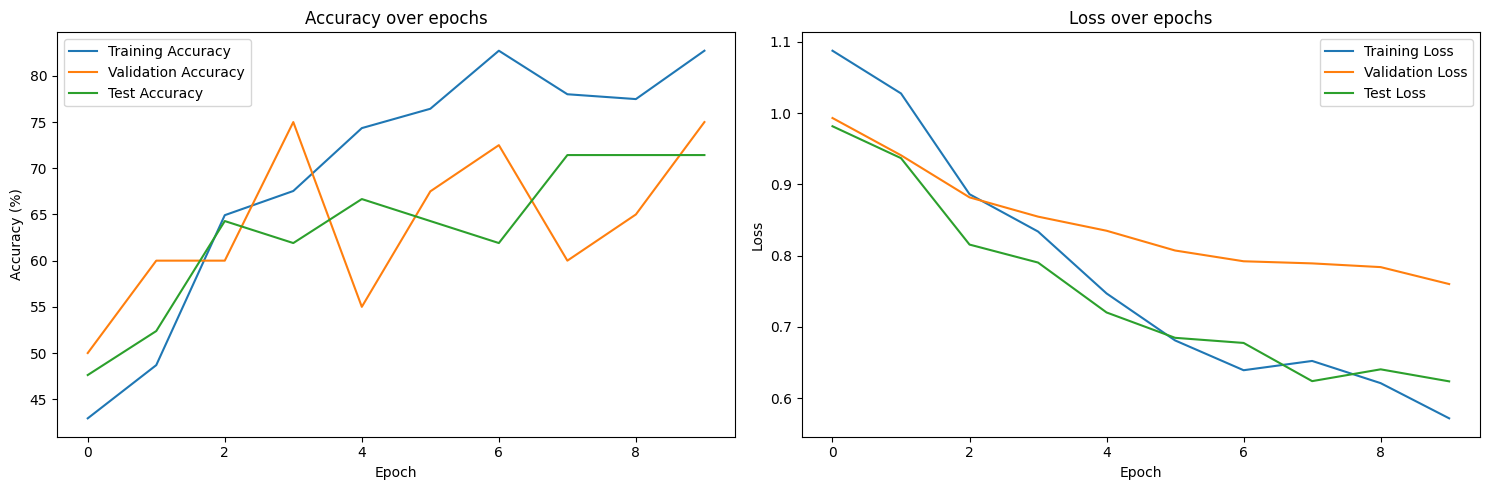


Final Metrics:
Best Training Accuracy: 82.72%
Best Validation Accuracy: 75.00%
Final Test Accuracy: 71.43%

Classification Report:
                 precision    recall  f1-score   support

        sitting       0.82      0.64      0.72        14
       standing       0.64      0.69      0.67        13
walking_running       0.71      0.80      0.75        15

       accuracy                           0.71        42
      macro avg       0.72      0.71      0.71        42
   weighted avg       0.72      0.71      0.71        42



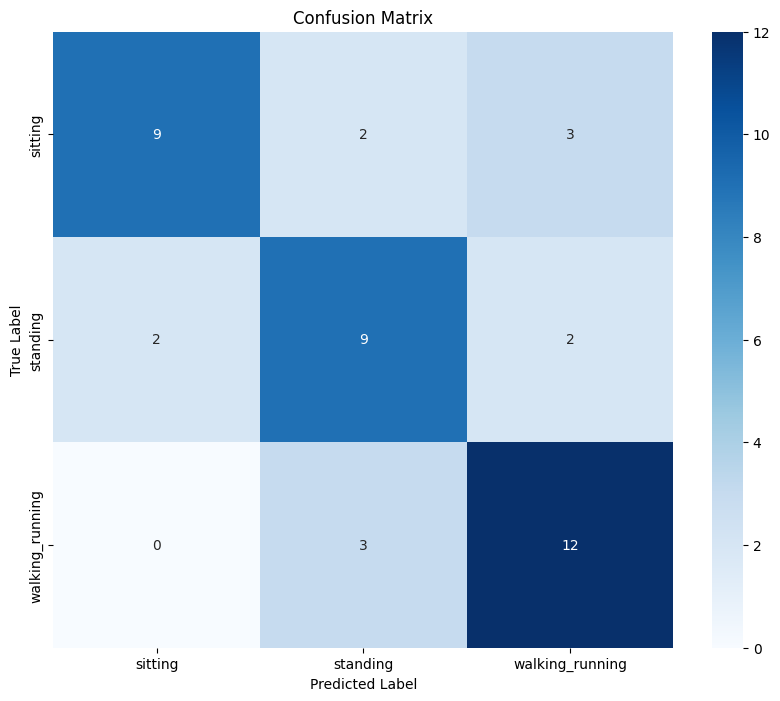

In [5]:
def create_final_model(num_classes=3):
    """Create model using feature_extraction strategy"""
    model = models.mobilenet_v2(pretrained=True)
    
    # Freeze all layers except classifier
    for param in model.parameters():
        param.requires_grad = False
    for param in model.classifier.parameters():
        param.requires_grad = True
    
    # Modify classifier for 3 classes
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    return model

def train_and_evaluate_final_model(train_loader, val_loader, test_loader, num_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Create model
    model = create_final_model(num_classes=3).to(device)
    
    # Setup optimizer and criterion
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    
    # Training history
    history = {
        'train_loss': [], 'val_loss': [], 'test_loss': [],
        'train_acc': [], 'val_acc': [], 'test_acc': []
    }
    
    best_val_loss = float('inf')
    patience = 3
    patience_counter = 0
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            train_total += labels.size(0)
            train_correct += predicted.eq(labels).sum().item()
        
        train_loss = train_loss / len(train_loader)
        train_acc = 100. * train_correct / train_total
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()
        
        val_loss = val_loss / len(val_loader)
        val_acc = 100. * val_correct / val_total
        
        # Test phase
        test_loss = 0.0
        test_correct = 0
        test_total = 0
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                test_loss += loss.item()
                _, predicted = outputs.max(1)
                test_total += labels.size(0)
                test_correct += predicted.eq(labels).sum().item()
                
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        test_loss = test_loss / len(test_loader)
        test_acc = 100. * test_correct / test_total
        
        # Store metrics
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['test_loss'].append(test_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['test_acc'].append(test_acc)
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Early stopping triggered after {epoch+1} epochs')
                break
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')
    
    # Load best model
    model.load_state_dict(torch.load('best_model.pth'))
    
    # Final evaluation on test set
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate metrics
    cm = confusion_matrix(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, 
                                 target_names=['sitting', 'standing', 'walking_running'])
    
    return history, cm, report

# Main execution
# Create dataset
datapaths = ['organized_images','organized_images_br']
for dataset in datapaths:
    print("Dataset path : ",dataset)
    dataset = datasets.ImageFolder(root='organized_images', transform=None)

    # Split dataset
    total_size = len(dataset)
    train_size = int(0.7 * total_size)
    val_size = int(0.15 * total_size)
    test_size = total_size - train_size - val_size

    train_dataset, val_dataset, test_dataset = random_split(
        dataset, [train_size, val_size, test_size]
    )

    # Apply transforms
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5],  # Standard normalization
                            std=[0.5, 0.5, 0.5])
    ])

    val_test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5],  # Standard normalization
                            std=[0.5, 0.5, 0.5])
    ])

    train_dataset.dataset.transform = train_transform
    val_dataset.dataset.transform = val_test_transform
    test_dataset.dataset.transform = val_test_transform

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Train and evaluate
    history, cm, report = train_and_evaluate_final_model(
        train_loader, val_loader, test_loader, num_epochs=10
    )

    # Plot results
    plt.figure(figsize=(15, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history['train_acc'], label='Training Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.plot(history['test_acc'], label='Test Accuracy')
    plt.title('Accuracy over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.plot(history['test_loss'], label='Test Loss')
    plt.title('Loss over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Print final metrics
    print("\nFinal Metrics:")
    print(f"Best Training Accuracy: {max(history['train_acc']):.2f}%")
    print(f"Best Validation Accuracy: {max(history['val_acc']):.2f}%")
    print(f"Final Test Accuracy: {history['test_acc'][-1]:.2f}%")

    print("\nClassification Report:")
    print(report)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['sitting', 'standing', 'walking_running'],
                yticklabels=['sitting', 'standing', 'walking_running'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

### clip

In [24]:
%pip install git+https://github.com/openai/CLIP.git

Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/openai/CLIP.git to c:\users\user\appdata\local\temp\pip-req-build-wb_wcidr
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git 'C:\Users\USER\AppData\Local\Temp\pip-req-build-wb_wcidr'

[notice] A new release of pip available: 22.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
from sklearn.model_selection import train_test_split
import clip

In [ ]:
IMAGE_SIZE = 224
BATCH_SIZE = 32
CLIP_MODEL = "ViT-B/32"   

def extract_label_from_filename(filename):
    """Extract label from filename pattern: {id}_{label}.jpg"""
   
    valid_labels = ['sitting', 'standing', 'walking_running']
    filename = filename.replace('.jpg', '')
    parts = filename.split('_')
    
    if len(parts) == 2:
        if parts[1] in valid_labels:
            return parts[1]
    elif len(parts) == 3:
        part = parts[1]+'_'+parts[2]
        if part in valid_labels:
            return part

    # If no valid label found, raise an error
    raise ValueError(f"Could not find valid label in filename: {filename}")

def get_label_mapping():
    """Create mapping between string labels and numerical values"""
    return {
        'sitting': 0,
        'standing': 1,
        'walking_running': 2
    }

def load_and_preprocess_image(image_path):
    """Load and preprocess image for CLIP"""
    image = Image.open(image_path).convert('RGB')
    image = image.resize((IMAGE_SIZE, IMAGE_SIZE))
    return image

def extract_clip_embeddings(image_paths, device):
    """Extract CLIP embeddings for a list of images"""
    # Load CLIP model
    model, preprocess = clip.load(CLIP_MODEL, device=device)
    
    embeddings = []
    for image_path in tqdm(image_paths, desc="Extracting embeddings"):
        # Load and preprocess image
        image = load_and_preprocess_image(image_path)
        image_input = preprocess(image).unsqueeze(0).to(device)
        
        # Extract embedding
        with torch.no_grad():
            image_features = model.encode_image(image_input)
            image_features /= image_features.norm(dim=-1, keepdim=True)
            embeddings.append(image_features.cpu().numpy())
    
    return np.vstack(embeddings)

def prepare_data(image_dir):
    """Main function to prepare the data"""
    # Get all image paths
    image_paths = []
    labels = []
    
    # Process images
    for filename in os.listdir(image_dir):
        if filename.endswith('.jpg'):
            image_paths.append(os.path.join(image_dir, filename))
            labels.append(extract_label_from_filename(filename))
    
    # Convert string labels to numerical values
    label_mapping = get_label_mapping()
    numerical_labels = [label_mapping[label] for label in labels]
    
    # First split: separate out test set (20%)
    train_val_paths, test_paths, train_val_labels, test_labels = train_test_split(
        image_paths, numerical_labels, test_size=0.2, random_state=42, stratify=numerical_labels
    )
    
    # Second split: split remaining data into train (75%) and validation (25%)
    # This gives us 60% train, 20% validation, 20% test
    train_paths, val_paths, train_labels, val_labels = train_test_split(
        train_val_paths, train_val_labels, test_size=0.25, random_state=42, stratify=train_val_labels
    )
    
    # Set up device
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")
    
    # Extract embeddings
    print("Extracting embeddings for training set...")
    train_embeddings = extract_clip_embeddings(train_paths, device)
    
    print("Extracting embeddings for validation set...")
    val_embeddings = extract_clip_embeddings(val_paths, device)
    
    print("Extracting embeddings for test set...")
    test_embeddings = extract_clip_embeddings(test_paths, device)
    
    # Create metadata
    metadata = {
        'label_mapping': label_mapping,
        'train_size': len(train_paths),
        'val_size': len(val_paths),
        'test_size': len(test_paths),
        'embedding_dim': train_embeddings.shape[1]
    }
    
    print("Data preparation complete!")
    print(f"Training set size: {len(train_paths)}")
    print(f"Validation set size: {len(val_paths)}")
    print(f"Test set size: {len(test_paths)}")
    
    return {
        'train_embeddings': train_embeddings,
        'val_embeddings': val_embeddings,
        'test_embeddings': test_embeddings,
        'train_labels': train_labels,
        'val_labels': val_labels,
        'test_labels': test_labels,
        'metadata': metadata
    }

# Define path
image_dir = "images"

# Run data preparation
data = prepare_data(image_dir)

train_embeddings = data['train_embeddings']
val_embeddings = data['val_embeddings']
test_embeddings = data['test_embeddings']
train_labels = data['train_labels']
val_labels = data['val_labels']
test_labels = data['test_labels']
metadata = data['metadata']

Using device: cpu
Extracting embeddings for training set...


Extracting embeddings: 100%|██████████| 163/163 [00:12<00:00, 13.36it/s]


Extracting embeddings for validation set...


Extracting embeddings: 100%|██████████| 55/55 [00:04<00:00, 13.60it/s]


Extracting embeddings for test set...


Extracting embeddings: 100%|██████████| 55/55 [00:04<00:00, 13.51it/s]

Data preparation complete!
Training set size: 163
Validation set size: 55
Test set size: 55


Training:  40%|████      | 20/50 [00:00<00:00, 67.96it/s]

Epoch [5/50], Train Loss: 1.1403, Train Acc: 85.28%, Val Loss: 1.0268, Val Acc: 63.64%, Patience: 0/5
Epoch [10/50], Train Loss: 0.7688, Train Acc: 87.73%, Val Loss: 0.8974, Val Acc: 65.45%, Patience: 0/5
Epoch [15/50], Train Loss: 0.4802, Train Acc: 89.57%, Val Loss: 0.8155, Val Acc: 67.27%, Patience: 0/5
Epoch [20/50], Train Loss: 0.3212, Train Acc: 94.48%, Val Loss: 0.7880, Val Acc: 65.45%, Patience: 0/5


Training:  54%|█████▍    | 27/50 [00:00<00:00, 61.70it/s]


Epoch [25/50], Train Loss: 0.2156, Train Acc: 97.55%, Val Loss: 0.7856, Val Acc: 69.09%, Patience: 2/5

Early stopping triggered at epoch 28


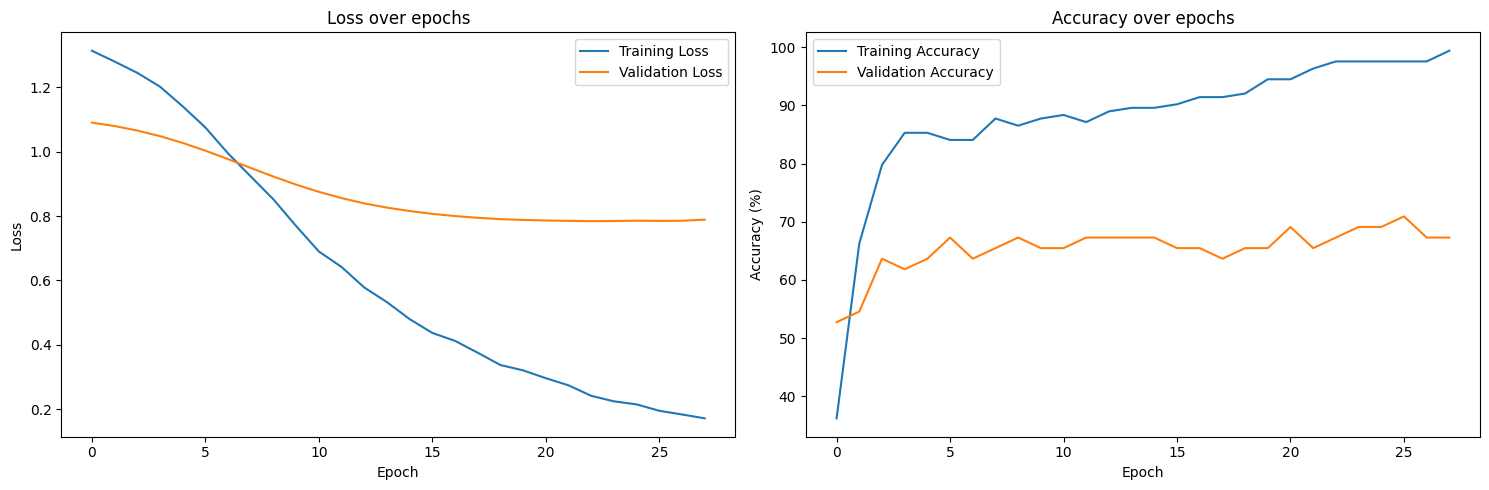

In [8]:
def create_classifier(input_dim=512, hidden_dim=256, num_classes=3):
    """Creates a sequential neural network model"""
    model = nn.Sequential(
        nn.Linear(input_dim, hidden_dim),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(hidden_dim, num_classes)
    )
    return model

def train_model(model, train_embeddings, train_labels, val_embeddings, val_labels, 
                                  num_epochs=50, batch_size=32, learning_rate=0.001, patience=5):
    # Convert numpy arrays to PyTorch tensors
    train_embeddings = torch.FloatTensor(train_embeddings)
    train_labels = torch.LongTensor(train_labels)
    val_embeddings = torch.FloatTensor(val_embeddings)
    val_labels = torch.LongTensor(val_labels)
    
    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Lists to store metrics
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    # Early stopping variables
    best_val_loss = float('inf')
    best_model_state = None
    patience_counter = 0
    
    # Training loop
    for epoch in tqdm(range(num_epochs), desc="Training"):
        model.train()
        total_loss = 0
        correct = 0
        total = 0
        
        # Training
        for i in range(0, len(train_embeddings), batch_size):
            # Get batch
            batch_embeddings = train_embeddings[i:i+batch_size]
            batch_labels = train_labels[i:i+batch_size]
            
            # Forward pass
            outputs = model(batch_embeddings)
            loss = criterion(outputs, batch_labels)
            
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Calculate metrics
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += batch_labels.size(0)
            correct += (predicted == batch_labels).sum().item()
        
        # Calculate training metrics
        train_loss = total_loss / (len(train_embeddings) // batch_size)
        train_accuracy = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        
        # Validation
        model.eval()
        with torch.no_grad():
            val_outputs = model(val_embeddings)
            val_loss = criterion(val_outputs, val_labels)
            _, val_predicted = torch.max(val_outputs.data, 1)
            val_accuracy = 100 * (val_predicted == val_labels).sum().item() / len(val_labels)
            
            val_losses.append(val_loss.item())
            val_accuracies.append(val_accuracy)
        
        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
        
        # Print progress
        if (epoch + 1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, '
                  f'Val Loss: {val_loss.item():.4f}, Val Acc: {val_accuracy:.2f}%, '
                  f'Patience: {patience_counter}/{patience}')
        
        # Check if early stopping condition met
        if patience_counter >= patience:
            print(f'\nEarly stopping triggered at epoch {epoch+1}')
            # Load best model
            model.load_state_dict(best_model_state)
            break
    
    return model, train_losses, val_losses, train_accuracies, val_accuracies

def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot losses
    ax1.plot(train_losses, label='Training Loss')
    ax1.plot(val_losses, label='Validation Loss')
    ax1.set_title('Loss over epochs')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    
    # Plot accuracies
    ax2.plot(train_accuracies, label='Training Accuracy')
    ax2.plot(val_accuracies, label='Validation Accuracy')
    ax2.set_title('Accuracy over epochs')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

def evaluate_model(model, test_embeddings, test_labels):
    model.eval()
    test_embeddings = torch.FloatTensor(test_embeddings)
    test_labels = torch.LongTensor(test_labels)
    
    with torch.no_grad():
        outputs = model(test_embeddings)
        _, predicted = torch.max(outputs.data, 1)
        
        # Calculate accuracy
        accuracy = 100 * (predicted == test_labels).sum().item() / len(test_labels)
        
        # Confusion matrix
        cm = confusion_matrix(test_labels, predicted)
        
# Create model
model = create_classifier()

# Train model
model, train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, 
    data['train_embeddings'], 
    data['train_labels'],
    data['val_embeddings'],
    data['val_labels'],
    num_epochs=50
)

# Plot metrics (using the same plotting function as before)
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

# Evaluate (using the same evaluation function as before)
# evaluate_model(model, data['test_embeddings'], data['test_labels'])

In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report


=== Overall Metrics ===
Accuracy: 0.6545
Precision: 0.6464
Recall: 0.6545
F1 Score: 0.6482


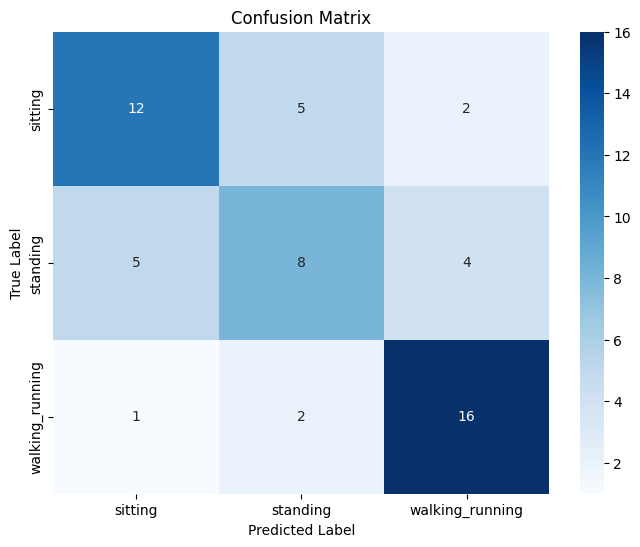


=== Detailed Classification Report ===
                 precision    recall  f1-score   support

        sitting       0.67      0.63      0.65        19
       standing       0.53      0.47      0.50        17
walking_running       0.73      0.84      0.78        19

       accuracy                           0.65        55
      macro avg       0.64      0.65      0.64        55
   weighted avg       0.65      0.65      0.65        55


=== Per-Class Metrics ===

sitting:
Precision: 0.6667
Recall: 0.6316
F1 Score: 0.6486

standing:
Precision: 0.5333
Recall: 0.4706
F1 Score: 0.5000

walking_running:
Precision: 0.7273
Recall: 0.8421
F1 Score: 0.7805


{'accuracy': 0.6545454545454545,
 'precision': 0.6463911845730028,
 'recall': 0.6545454545454545,
 'f1': 0.6482471384910409,
 'confusion_matrix': array([[12,  5,  2],
        [ 5,  8,  4],
        [ 1,  2, 16]], dtype=int64)}

In [10]:
def evaluate_model_with_test_data(model, test_embeddings, test_labels):
    # Convert to tensors
    test_embeddings = torch.FloatTensor(test_embeddings)
    test_labels = torch.LongTensor(test_labels)
    
    # Set model to evaluation mode
    model.eval()
    
    # Get predictions
    with torch.no_grad():
        outputs = model(test_embeddings)
        _, predicted = torch.max(outputs.data, 1)
    
    # Convert to numpy for sklearn metrics
    y_true = test_labels.numpy()
    y_pred = predicted.numpy()
    
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    # Print metrics
    print("\n=== Overall Metrics ===")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['sitting', 'standing', 'walking_running'],
                yticklabels=['sitting', 'standing', 'walking_running'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # Detailed classification report
    print("\n=== Detailed Classification Report ===")
    print(classification_report(y_true, y_pred, 
                              target_names=['sitting', 'standing', 'walking_running']))
    
    # Per-class metrics
    print("\n=== Per-Class Metrics ===")
    for i, class_name in enumerate(['sitting', 'standing', 'walking_running']):
        class_precision = precision_score(y_true, y_pred, labels=[i], average='micro')
        class_recall = recall_score(y_true, y_pred, labels=[i], average='micro')
        class_f1 = f1_score(y_true, y_pred, labels=[i], average='micro')
        
        print(f"\n{class_name}:")
        print(f"Precision: {class_precision:.4f}")
        print(f"Recall: {class_recall:.4f}")
        print(f"F1 Score: {class_f1:.4f}")
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm
    }

evaluate_model_with_test_data(model, data['test_embeddings'], data['test_labels'])

## task 5 - embeddings 2 - label embedding with cosine similarities

In [11]:
import torch.nn.functional as F

Using device: cpu
Extracting embeddings for training set...


Extracting embeddings: 100%|██████████| 163/163 [00:12<00:00, 13.37it/s]


Extracting embeddings for validation set...


Extracting embeddings: 100%|██████████| 55/55 [00:04<00:00, 13.64it/s]


Extracting embeddings for test set...


Extracting embeddings: 100%|██████████| 55/55 [00:04<00:00, 13.63it/s]


Data preparation complete!
Training set size: 163
Validation set size: 55
Test set size: 55
Train similarities range: 0.1599198877811432 0.30318644642829895
Val similarities range: 0.147680401802063 0.28934186697006226
Test similarities range: 0.1582757830619812 0.27478906512260437


Training:  10%|█         | 5/50 [00:00<00:01, 44.65it/s]

Epoch [5/50], Train Loss: 1.1230, Train Acc: 82.21%, Val Loss: 1.0100, Val Acc: 61.82%, Patience: 0/5


Training:  20%|██        | 10/50 [00:00<00:00, 46.75it/s]

Epoch [10/50], Train Loss: 0.4111, Train Acc: 89.57%, Val Loss: 0.8237, Val Acc: 63.64%, Patience: 0/5


Training:  30%|███       | 15/50 [00:00<00:00, 41.91it/s]

Epoch [15/50], Train Loss: 0.1049, Train Acc: 98.77%, Val Loss: 0.9240, Val Acc: 67.27%, Patience: 4/5

Early stopping triggered at epoch 16
Importance of cosine similarity features:
tensor([0.0285, 0.0264, 0.0274])

Average importance:
Original features: 0.030566353350877762
Cosine similarity features: 0.027447409927845


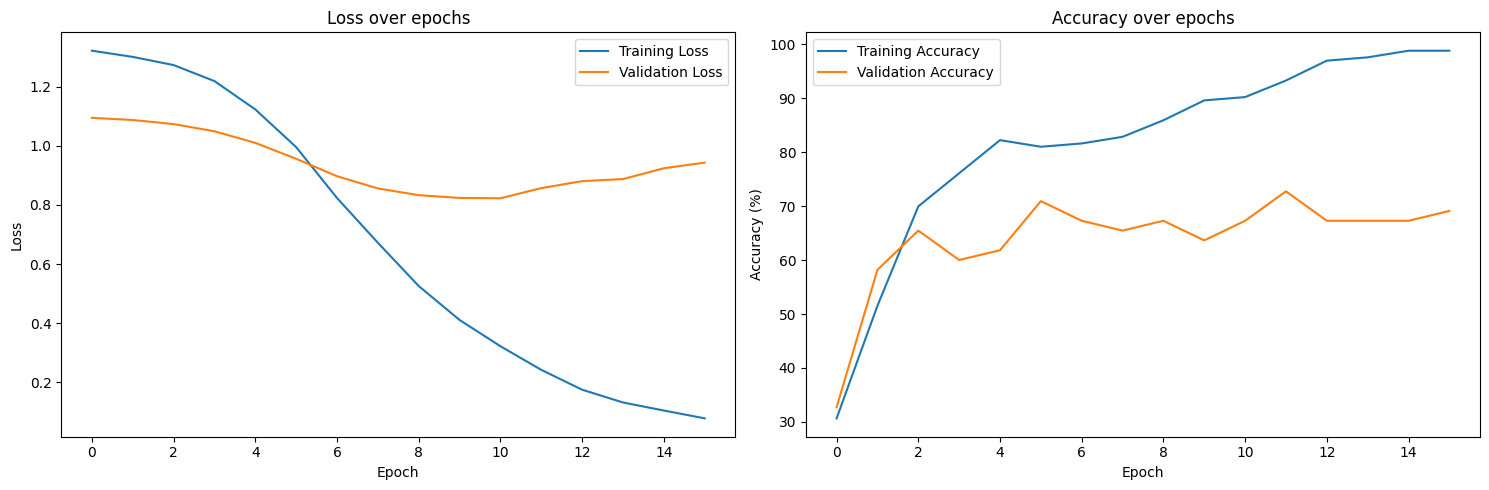

In [ ]:
def get_label_embeddings(model, device):
    class_prompts = [
        "a person sitting",
        "a person standing",
        "a person walking or running"
    ]
    
    # Tokenize and encode the prompts
    text = clip.tokenize(class_prompts).to(device)
    
    # Get embeddings
    with torch.no_grad():
        text_features = model.encode_text(text)
        text_features /= text_features.norm(dim=-1, keepdim=True)
    
    return text_features

def calculate_cosine_similarities(image_embeddings, label_embeddings):
    """Calculate cosine similarities between image embeddings and label embeddings"""
    # Normalize the embeddings
    image_embeddings = F.normalize(image_embeddings, dim=1)
    label_embeddings = F.normalize(label_embeddings, dim=1)
    
    # Calculate cosine similarities
    similarities = torch.mm(image_embeddings, label_embeddings.t())
    
    return similarities

def enhance_features_with_label_similarities(train_embeddings, val_embeddings, test_embeddings):
    """Enhance the embeddings with label similarity features"""
    # Load CLIP model
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model, _ = clip.load("ViT-B/32", device=device)
    
    # Get label embeddings
    label_embeddings = get_label_embeddings(model, device)
    
    # Calculate similarities for each set
    train_similarities = calculate_cosine_similarities(torch.FloatTensor(train_embeddings), label_embeddings)
    val_similarities = calculate_cosine_similarities(torch.FloatTensor(val_embeddings), label_embeddings)
    test_similarities = calculate_cosine_similarities(torch.FloatTensor(test_embeddings), label_embeddings)
    
    print("Train similarities range:", train_similarities.min().item(), train_similarities.max().item())
    print("Val similarities range:", val_similarities.min().item(), val_similarities.max().item())
    print("Test similarities range:", test_similarities.min().item(), test_similarities.max().item())
    # Combine original embeddings with similarity features
    enhanced_train = np.hstack([train_embeddings, train_similarities.cpu().numpy()])
    enhanced_val = np.hstack([val_embeddings, val_similarities.cpu().numpy()])
    enhanced_test = np.hstack([test_embeddings, test_similarities.cpu().numpy()])
    
    return enhanced_train, enhanced_val, enhanced_test

def create_classifier_2(input_dim=515, hidden_dim=256, num_classes=3):
    """Creates a sequential neural network model with better feature utilization"""
    model = nn.Sequential(
        nn.Linear(input_dim, hidden_dim),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(hidden_dim, hidden_dim), 
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(hidden_dim, num_classes)
    )
    return model

def check_feature_importance(model, test_embeddings):
    """Check which features are being used by the model"""
    # Get the weights of the first layer
    weights = model[0].weight.data
    
    # Calculate the average absolute weight for each feature
    feature_importance = torch.mean(torch.abs(weights), dim=0)
    
    # Print the importance of the last 3 features (cosine similarities)
    print("Importance of cosine similarity features:")
    print(feature_importance[-3:])
    
    # Print the average importance of original features vs new features
    print("\nAverage importance:")
    print("Original features:", torch.mean(feature_importance[:-3]).item())
    print("Cosine similarity features:", torch.mean(feature_importance[-3:]).item())


data_lb = prepare_data(image_dir)

# Enhance the features with label similarities
enhanced_train, enhanced_val, enhanced_test = enhance_features_with_label_similarities(
    data_lb['train_embeddings'],
    data_lb['val_embeddings'],
    data_lb['test_embeddings']
)

# Update the data dictionary with enhanced features
data_lb['train_embeddings'] = enhanced_train
data_lb['val_embeddings'] = enhanced_val
data_lb['test_embeddings'] = enhanced_test

# Train and evaluate 
model = create_classifier_2(input_dim=515)  # 512 (original) + 3 (similarities)
model, train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, 
    enhanced_train, 
    data_lb['train_labels'],
    enhanced_val,
    data_lb['val_labels'],
    num_epochs=50
)

check_feature_importance(model, enhanced_test)
# Plot metrics
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

# Evaluate
# metrics = evaluate_model(model, data_lb['test_embeddings'], data_lb['test_labels'])


=== Overall Metrics ===
Accuracy: 0.6909
Precision: 0.6889
Recall: 0.6909
F1 Score: 0.6885


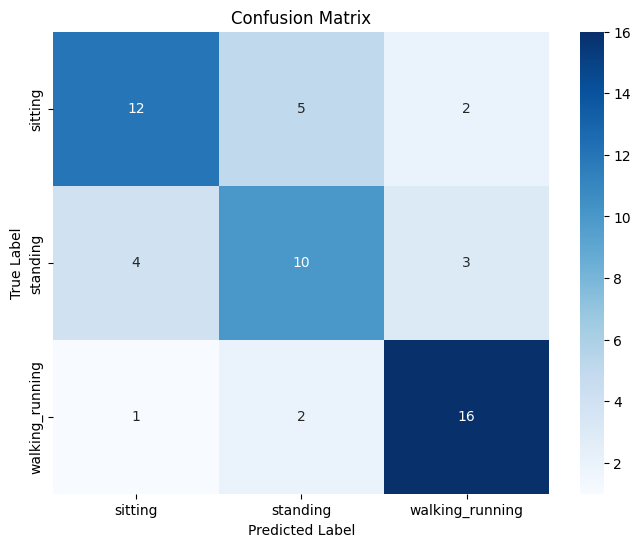


=== Detailed Classification Report ===
                 precision    recall  f1-score   support

        sitting       0.71      0.63      0.67        19
       standing       0.59      0.59      0.59        17
walking_running       0.76      0.84      0.80        19

       accuracy                           0.69        55
      macro avg       0.69      0.69      0.68        55
   weighted avg       0.69      0.69      0.69        55


=== Per-Class Metrics ===

sitting:
Precision: 0.7059
Recall: 0.6316
F1 Score: 0.6667

standing:
Precision: 0.5882
Recall: 0.5882
F1 Score: 0.5882

walking_running:
Precision: 0.7619
Recall: 0.8421
F1 Score: 0.8000


{'accuracy': 0.6909090909090909,
 'precision': 0.6888719124013242,
 'recall': 0.6909090909090909,
 'f1': 0.6884848484848485,
 'confusion_matrix': array([[12,  5,  2],
        [ 4, 10,  3],
        [ 1,  2, 16]], dtype=int64)}

In [13]:
evaluate_model_with_test_data(model, data_lb['test_embeddings'], data_lb['test_labels'])